<a href="https://colab.research.google.com/github/Yu-Jie06/Model/blob/main/LSTM%2CGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-06-15 08:53:51--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.251.189.138, 142.251.189.113, 142.251.189.101, ...
Connecting to drive.google.com (drive.google.com)|142.251.189.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-06-15 08:53:51--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.206.132, 2607:f8b0:4001:c62::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.206.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M   123MB/s    in 0.2s    

2025-06-15 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#單層LSTM和GRU
#可以選擇或者刪除欄位
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import os
import argparse

# 如果TensorFlow顯示太多訊息，可以設置為只顯示錯誤
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 1. 加載和預處理數據
# 修改 load_and_preprocess_data，接受 drop_columns 參數和select_columns參數
def load_and_preprocess_data(file_path, drop_columns=None, select_columns=None):
    df = pd.read_csv(file_path)

    # 如果有選擇特定欄位
    if select_columns:
        print(f"僅保留欄位: {select_columns}")
        df = df[select_columns]

    # 如果有傳入需要刪除的欄位（注意不能同時用 drop 和 select）
    elif drop_columns:
        print(f"移除欄位: {drop_columns}")
        df = df.drop(columns=drop_columns)

    # 日期處理與排序
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # 移除缺失值
    df_clean = df.dropna()

    print(f"原始數據行數: {len(df)}")
    print(f"刪除缺失值後的行數: {len(df_clean)}")
    print(f"刪除了 {len(df) - len(df_clean)} 行")
    print(f"處理後的缺失值數量: {df_clean.isnull().sum().sum()}")

    return df_clean



# 2. 特徵工程
def feature_engineering(df):
    # 選擇數值型特徵
    print("特徵欄位:", df.columns[2:-1])

    features = df[df.columns[2:-1]]
    # 標準化特徵
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    # 目標變數
    target = df['target'].values

    return scaled_features, target, scaler


# 3. 創建模型(要改模型的組合、參數、都是在這改)
def create_model(input_shape, model_type='gru'):
    model = Sequential()

    if model_type.lower() == 'lstm':
        model.add(LSTM(64, return_sequences=False, input_shape=input_shape,
                       dropout=0.2, recurrent_dropout=0.2))
    else:
        model.add(GRU(64, return_sequences=False, input_shape=input_shape,
                      dropout=0.2, recurrent_dropout=0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # 二元分類

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),#使用Adam優化器
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

# 4. 重塑數據以適合模型輸入格式
def reshape_for_rnn(X):
    # 為RNN添加時間步維度 [樣本, 時間步, 特徵]
    # 由於我們的任務是同一行預測，時間步設為1
    return X.reshape(X.shape[0], 1, X.shape[1])

# 5. 訓練和評估模型
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='gru', epochs=50, batch_size=32):
    # 重塑訓練和測試數據
    X_train_reshaped = reshape_for_rnn(X_train)
    X_test_reshaped = reshape_for_rnn(X_test)

    # 創建模型
    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
    model = create_model(input_shape, model_type)

    # 早停設置以防止過擬合
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # 訓練模型
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2, #從訓練集的80%中拿出20%作為驗證集
        callbacks=[early_stopping],
        verbose=1
    )

    # 評估模型
    y_pred_prob = model.predict(X_test_reshaped, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # 計算準確率
    accuracy = accuracy_score(y_test, y_pred)
    print(f'測試集準確率: {accuracy:.4f}')

    # 分類報告
    print("\n分類報告:")
    print(classification_report(y_test, y_pred))

    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('預測值')
    plt.ylabel('實際值')
    plt.title(f'混淆矩陣 ({model_type.upper()})')


    # 繪製訓練過程中的損失和準確率
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='訓練損失')
    plt.plot(history.history['val_loss'], label='驗證損失')
    plt.title('模型損失')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='訓練準確率')
    plt.plot(history.history['val_accuracy'], label='驗證準確率')
    plt.title('模型準確率')
    plt.xlabel('Epoch')
    plt.ylabel('準確率')
    plt.legend()


    return model, history

# 特徵重要性計算方法
def calculate_feature_importance(model, X_test, feature_names):
    """使用簡單的排列特徵重要性方法，不依賴於外部庫"""
    print("計算特徵重要性...")

    # 重塑測試數據
    X_test_reshaped = reshape_for_rnn(X_test)

    # 獲取基準準確率
    y_pred_base = model.predict(X_test_reshaped, verbose=0)

    # 特徵重要性存儲
    feature_importance = []

    # 對於每個特徵
    for i in range(X_test.shape[1]):
        print(f"評估特徵 {i+1}/{X_test.shape[1]}: {feature_names[i]}")

        # 創建數據副本
        X_permuted = X_test.copy()

        # 打亂特定特徵
        np.random.shuffle(X_permuted[:, i])

        # 重塑數據
        X_permuted_reshaped = reshape_for_rnn(X_permuted)

        # 使用打亂後的數據進行預測
        y_pred_permuted = model.predict(X_permuted_reshaped, verbose=0)

        # 計算預測差異
        importance = np.mean(np.abs(y_pred_base - y_pred_permuted))
        feature_importance.append(importance)

    return np.array(feature_importance)


# 主程序，整合LSTM和GRU模型
def main(file_path, model_type='gru', epochs=50, batch_size=32, drop_columns=None,select_columns=None): #這邊記得要加drop_columns和select_columns才可以在下面選擇或刪除欄位
    try:
        # 確保TensorFlow環境乾淨
        tf.keras.backend.clear_session()

        print(f"\n=== 使用 {model_type.upper()} 模型進行股票漲跌預測 ===\n")

        # 加載和預處理數據，傳入 drop_columns
        df = load_and_preprocess_data(file_path, drop_columns=drop_columns, select_columns=select_columns)

        # 接下來的操作和原來的一樣
        X, y, scaler = feature_engineering(df)

        # 數據分割 #test_size=0.2: 表示將數據分成測試集時，測試集的比例為總數據的 20%，而訓練集的比例為 80%。
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

        # 訓練和評估模型
        model, history = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type, epochs, batch_size)

        # 儲存模型等後續步驟
        #model.save(f'stock_prediction_{model_type}.h5')

        # 計算特徵重要性等
        feature_names = df.columns[2:-1].tolist()
        importance_scores = calculate_feature_importance(model, X_test, feature_names)

        # 繪製特徵重要性
        indices = np.argsort(importance_scores)[::-1]
        plt.figure(figsize=(12, 8))
        plt.title(f'特徵重要性 ({model_type.upper()})')
        plt.bar(range(len(feature_names)), importance_scores[indices])
        plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()

        return model, scaler  # 返回模型和scaler

    except Exception as e:
        print(f"執行中發生錯誤: {e}")
        import traceback
        traceback.print_exc()
        return None, None

    finally:
        tf.keras.backend.clear_session()


=== 使用 LSTM 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'sentiment_score', 'target']
原始數據行數: 1179
刪除缺失值後的行數: 1179
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['sentiment_score'], dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.5300 - loss: 0.6931 - val_accuracy: 0.7937 - val_loss: 0.6911
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5774 - loss: 0.6916 - val_accuracy: 0.5926 - val_loss: 0.6893
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5405 - loss: 0.6903 - val_accuracy: 0.5608 - val_loss: 0.6876
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5169 - loss: 0.6897 - val_accuracy: 0.5979 - val_loss: 0.6855
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5397 - loss: 0.6885 - val_accuracy: 0.5979 - val_loss: 0.6835
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5532 - loss: 0.6872 - val_accuracy: 0.7831 - val_loss: 0.6806
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6123 - loss: 0.6838 - val_accuracy: 0.7513 - val_loss: 0.6757
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5720 - loss: 0.6853 - val_accuracy: 0.7566 - val_loss

(<Sequential name=sequential, built=True>, MinMaxScaler())

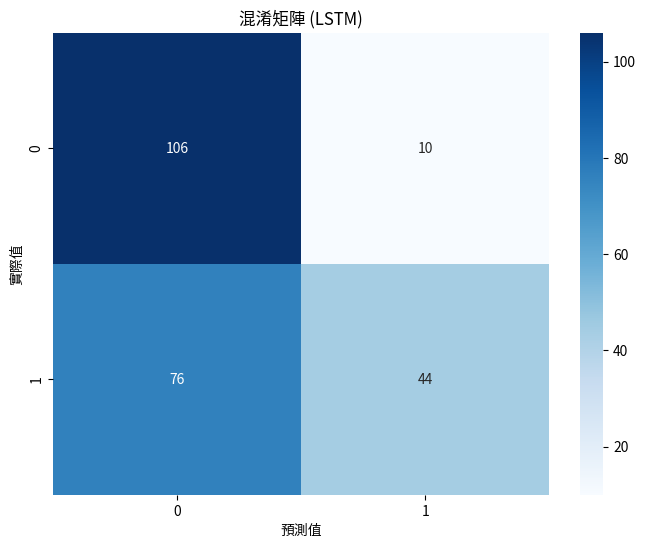

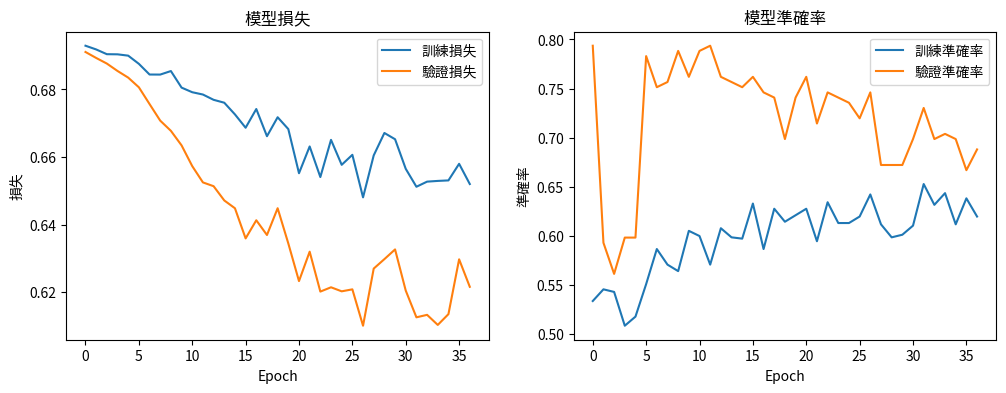

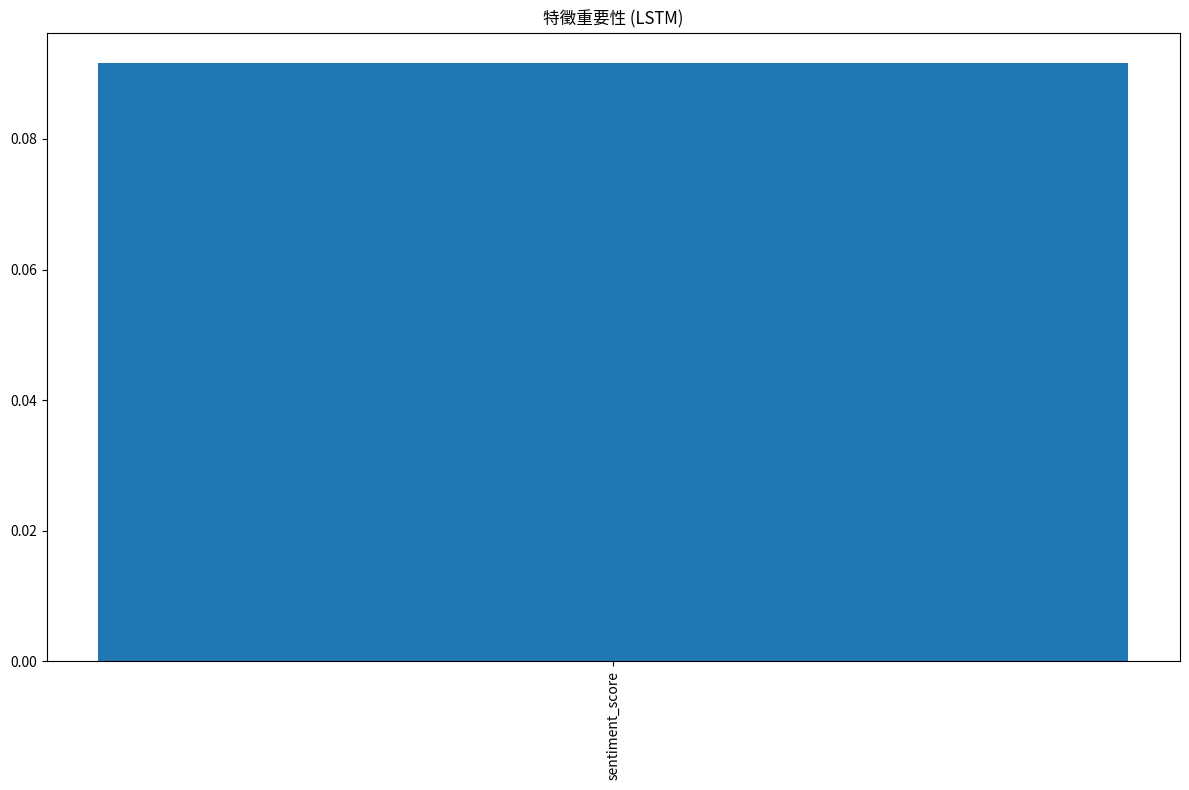

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/2454_stock_summary(1)_sentiment.csv", model_type='lstm', epochs=50, batch_size=32, select_columns=select_columns)


# 實作

In [ ]:
#雙層LSTM和GRU
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import os
import argparse
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

# 如果TensorFlow顯示太多訊息，可以設置為只顯示錯誤
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 1. 加載和預處理數據
# 修改 load_and_preprocess_data，接受 drop_columns 參數
def load_and_preprocess_data(file_path, drop_columns=None, select_columns=None):
    df = pd.read_csv(file_path)

    # 如果有選擇特定欄位
    if select_columns:
        print(f"僅保留欄位: {select_columns}")
        df = df[select_columns]

    # 如果有傳入需要刪除的欄位
    elif drop_columns:
        print(f"移除欄位: {drop_columns}")
        df = df.drop(columns=drop_columns)

    # 將日期轉換為datetime格式並按日期排序
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # 刪除含有缺失值的行
    df_clean = df.dropna()

    # 顯示原始數據和處理後的數據狀況
    print(f"原始數據行數: {len(df)}")
    print(f"刪除缺失值後的行數: {len(df_clean)}")
    print(f"刪除了 {len(df) - len(df_clean)} 行")

    missing_count = df_clean.isnull().sum().sum()
    print(f"處理後的缺失值數量: {missing_count}")

    return df_clean



# 2. 特徵工程
def feature_engineering(df):
    # 選擇數值型特徵
    print("特徵欄位:", df.columns[2:-1])

    features = df[df.columns[2:-1]]
    # 標準化特徵
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    # 目標變數
    target = df['target'].values

    return scaled_features, target, scaler


# 3. 創建模型(要改模型的組合、參數、都是在這改)
def create_model(input_shape, model_type='gru'):
    model = Sequential()

    if model_type.lower() == 'lstm':
        # 第一層LSTM，返回序列
        model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))

        # 第二層LSTM
        model.add(LSTM(units=32))
        model.add(Dropout(0.2))
    else:
        # 第一層GRU，返回序列
        model.add(GRU(units=64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))

        # 第二層GRU
        model.add(GRU(units=32))
        model.add(Dropout(0.2))

    # 輸出層 - 二元分類問題
    #model.add(Dense(64, activation='relu'))  # 對應前面 units=64
    #model.add(Dense(32, activation='relu'))  # 可進一步萃取特徵
    model.add(Dense(1, activation='sigmoid'))  # 輸出層

    # 指定學習率的 Adam 優化器
    #optimizer = Adam(learning_rate=0.005)
    # 編譯模型
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #若要指定learning_rate要修改這兩行


    # 編譯模型
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 顯示模型摘要
    model.summary()

    return model

# 4. 重塑數據以適合模型輸入格式
def reshape_for_rnn(X):
    # 為RNN添加時間步維度 [樣本, 時間步, 特徵]
    # 由於我們的任務是同一行預測，時間步設為1
    return X.reshape(X.shape[0], 1, X.shape[1])

# 5. 訓練和評估模型
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='gru', epochs=100, batch_size=32):
    # 重塑訓練和測試數據
    X_train_reshaped = reshape_for_rnn(X_train)
    X_test_reshaped = reshape_for_rnn(X_test)

    # 創建模型
    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
    model = create_model(input_shape, model_type)

    # 早停設置以防止過擬合
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    )

    # 訓練模型
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        shuffle=False,
        callbacks=[early_stopping],
        verbose=1
    )

    # 評估模型
    y_pred_prob = model.predict(X_test_reshaped, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)


    # 計算準確率
    accuracy = accuracy_score(y_test, y_pred)
    print(f'測試集準確率: {accuracy:.4f}')

    # 分類報告
    print("\n分類報告:")
    print(classification_report(y_test, y_pred))

    # 繪製 ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假陽性率 (False Positive Rate)')
    plt.ylabel('真陽性率 (True Positive Rate)')
    plt.title(f'ROC 曲線 ({model_type.upper()})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('預測值')
    plt.ylabel('實際值')
    plt.title(f'混淆矩陣 ({model_type.upper()})')


    # 繪製訓練過程中的損失和準確率
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='訓練損失')
    plt.plot(history.history['val_loss'], label='驗證損失')
    plt.title('模型損失')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='訓練準確率')
    plt.plot(history.history['val_accuracy'], label='驗證準確率')
    plt.title('模型準確率')
    plt.xlabel('Epoch')
    plt.ylabel('準確率')
    plt.legend()


    return model, history

# 特徵重要性計算方法
def calculate_feature_importance(model, X_test, feature_names):
    """使用簡單的排列特徵重要性方法，不依賴於外部庫"""
    print("計算特徵重要性...")

    # 重塑測試數據
    X_test_reshaped = reshape_for_rnn(X_test)

    # 獲取基準準確率
    y_pred_base = model.predict(X_test_reshaped, verbose=0)

    # 特徵重要性存儲
    feature_importance = []

    # 對於每個特徵
    for i in range(X_test.shape[1]):
        print(f"評估特徵 {i+1}/{X_test.shape[1]}: {feature_names[i]}")

        # 創建數據副本
        X_permuted = X_test.copy()

        # 打亂特定特徵
        np.random.shuffle(X_permuted[:, i])

        # 重塑數據
        X_permuted_reshaped = reshape_for_rnn(X_permuted)

        # 使用打亂後的數據進行預測
        y_pred_permuted = model.predict(X_permuted_reshaped, verbose=0)

        # 計算預測差異
        importance = np.mean(np.abs(y_pred_base - y_pred_permuted))
        feature_importance.append(importance)

    return np.array(feature_importance)


# 主程序，整合LSTM和GRU模型
def main(file_path, model_type='gru', epochs=100, batch_size=32, drop_columns=None, select_columns=None):
    try:
        # 確保TensorFlow環境乾淨
        tf.keras.backend.clear_session()

        print(f"\n=== 使用 {model_type.upper()} 模型進行股票漲跌預測 ===\n")

        # 加載和預處理數據，傳入 drop_columns
        df = load_and_preprocess_data(file_path, drop_columns=drop_columns, select_columns=select_columns)

        # 接下來的操作和原來的一樣
        X, y, scaler = feature_engineering(df)

        # 數據分割
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

        train_total = len(X_train)
        val_count = int(train_total * 0.2)
        actual_train_count = train_total - val_count
        test_count = len(X_test)

        print("\n📊 資料集切割筆數統計：")
        print(f"訓練集筆數（實際用於 model.fit）：{actual_train_count}")
        print(f"驗證集筆數（由訓練集中切分）     ：{val_count}")
        print(f"測試集筆數                      ：{test_count}")
        print(f"總筆數檢查（應為 {len(X)}）     ：{actual_train_count + val_count + test_count}")

        # 訓練和評估模型
        model, history = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type, epochs, batch_size)

        # 儲存模型等後續步驟
        #model.save(f'stock_prediction_{model_type}.h5')

        # 計算特徵重要性等
        feature_names = df.columns[2:-1].tolist()
        importance_scores = calculate_feature_importance(model, X_test, feature_names)

        # 繪製特徵重要性
        indices = np.argsort(importance_scores)[::-1]
        plt.figure(figsize=(12, 8))
        plt.title(f'特徵重要性 ({model_type.upper()})')
        plt.bar(range(len(feature_names)), importance_scores[indices])
        plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()

        return model, scaler  # 返回模型和scaler

    except Exception as e:
        print(f"執行中發生錯誤: {e}")
        import traceback
        traceback.print_exc()
        return None, None

    finally:
        tf.keras.backend.clear_session()


In [ ]:
main("/content/drive/MyDrive/Regularization/FinGPT Final/2379_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, drop_columns=drop_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

移除欄位: ['spread']
原始數據行數: 1216
刪除缺失值後的行數: 1210
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'RSI', 'MA', 'FastK', 'FastD', 'Dividend Yield',
       'P/E', 'P/B', 'sentiment_score'],
      dtype='object')

📊 資料集切割筆數統計：
訓練集筆數（實際用於 model.fit）：775
驗證集筆數（由訓練集中切分）     ：193
測試集筆數                      ：242
總筆數檢查（應為 1210）     ：1210


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,993 (97.63 KB)

 Trainable params: 24,993 (97.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5172 - loss: 0.6889 - val_accuracy: 0.5515 - val_loss: 0.6763
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5762 - loss: 0.6713 - val_accuracy: 0.7113 - val_loss: 0.6501
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6602 - loss: 0.6471 - val_accuracy: 0.7216 - val_loss: 0.6100
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6755 - loss: 0.6119 - val_accuracy: 0.7423 - val_loss: 0.5652
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7027 - loss: 0.5768 - val_accuracy: 0.7629 - val_loss: 0.5271
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6996 - loss: 0.5483 - val_accuracy: 0.7526 - val_loss: 0.5062
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6958 - loss: 0.5482 - val_accuracy: 0.7474 - val_loss: 0.4977
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7360 - loss: 0.5300 - val_accuracy: 0.7629 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

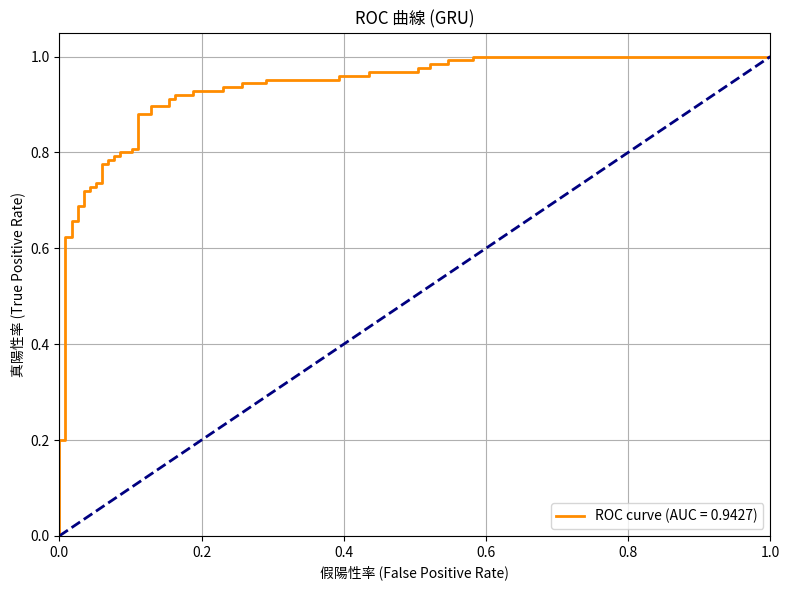

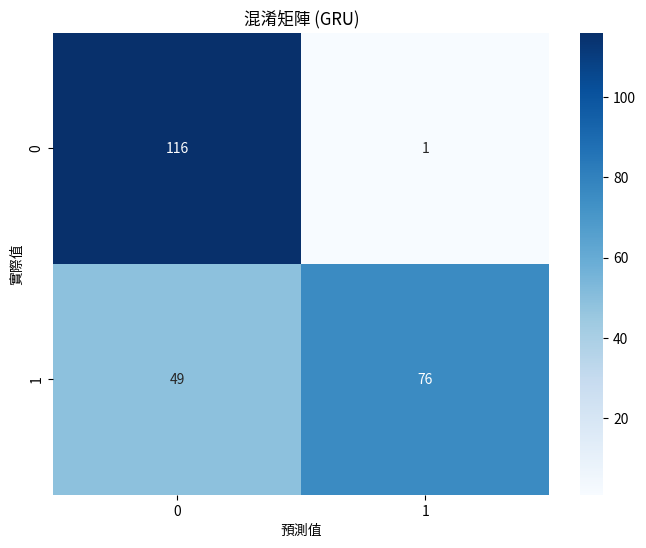

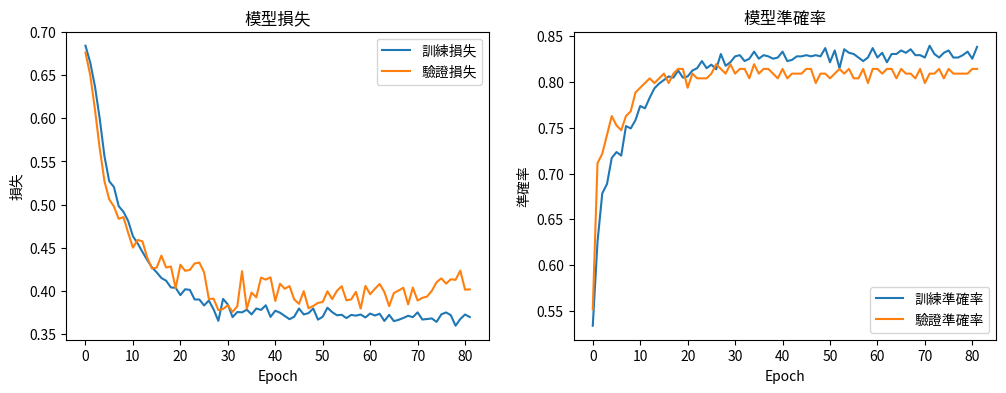

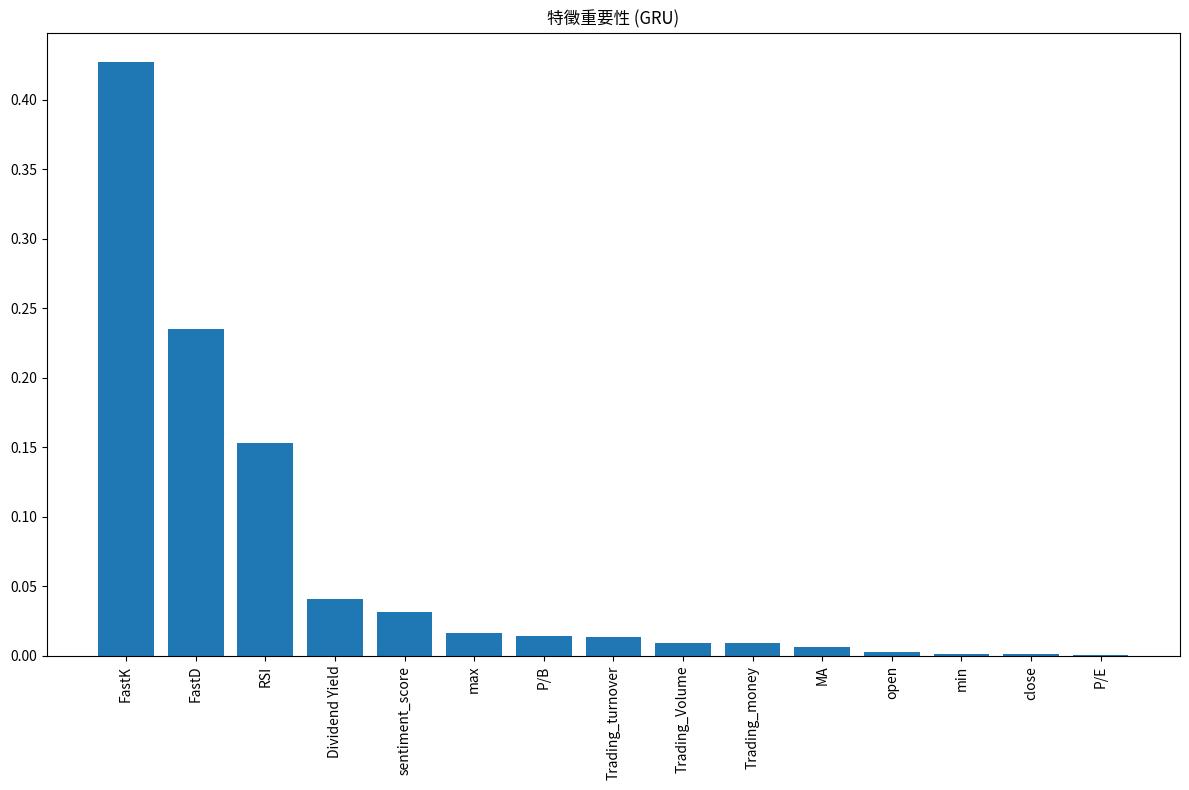

In [ ]:
# 執行程式時傳入要排除的欄位名稱→要把漲跌幅拿掉，因為漲跌幅+/-會影響到，怕提前知道答案
drop_columns = ['spread']  # 要排除的欄位名稱
main("/content/drive/MyDrive/Regularization/3037_stock_summary(1)_sentiment.csv", model_type='gru', epochs=100, batch_size=32, drop_columns=drop_columns)

# 特徵組合:消融實驗比較


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'Dividend Yield', 'P/E', 'P/B', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1210
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'Dividend Yield',
       'P/E', 'P/B'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801 (96.88 KB)

 Trainable params: 24,801 (96.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.6117 - loss: 0.6861 - val_accuracy: 0.6495 - val_loss: 0.6700
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6937 - loss: 0.6633 - val_accuracy: 0.6804 - val_loss: 0.6424
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6691 - loss: 0.6403 - val_accuracy: 0.6753 - val_loss: 0.6085
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6816 - loss: 0.6108 - val_accuracy: 0.6753 - val_loss: 0.5761
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6856 - loss: 0.5850 - val_accuracy: 0.6753 - val_loss: 0.5590
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7291 - loss: 0.5440 - val_accuracy: 0.7423 - val_loss: 0.5587
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7523 - loss: 0.5216 - val_accuracy: 0.7526 - val_loss: 0.5646
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7391 - loss: 0.5127 - val_accuracy: 0.

(<Sequential name=sequential, built=True>, MinMaxScaler())

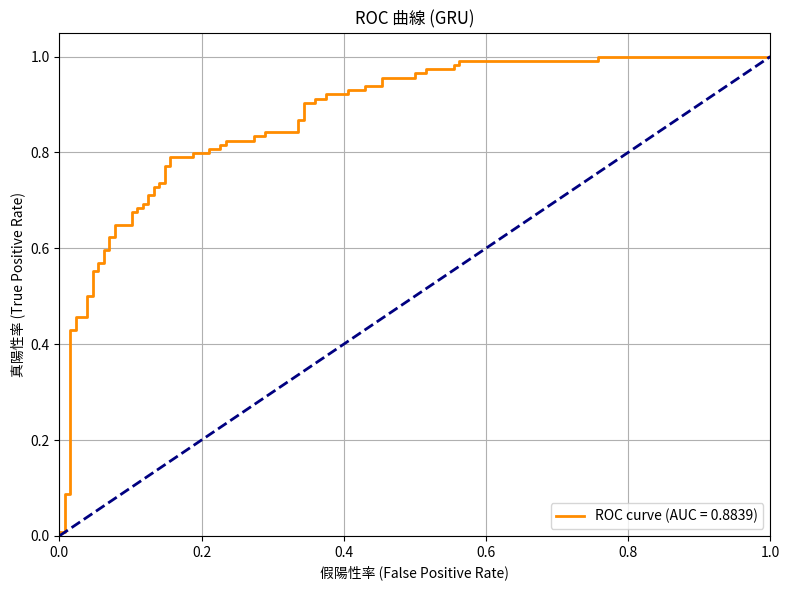

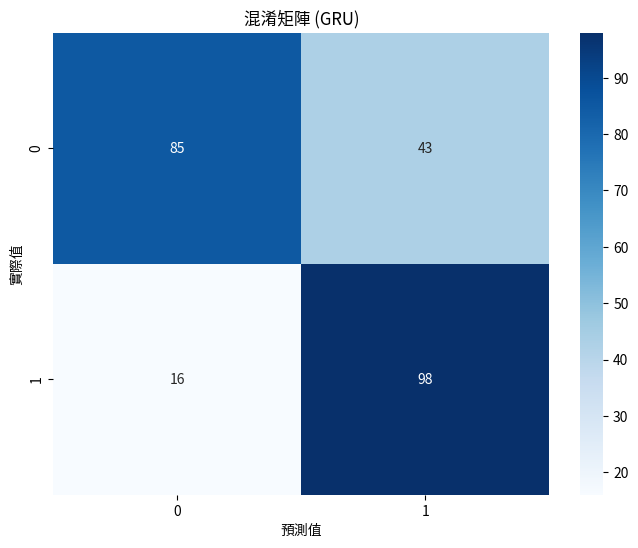

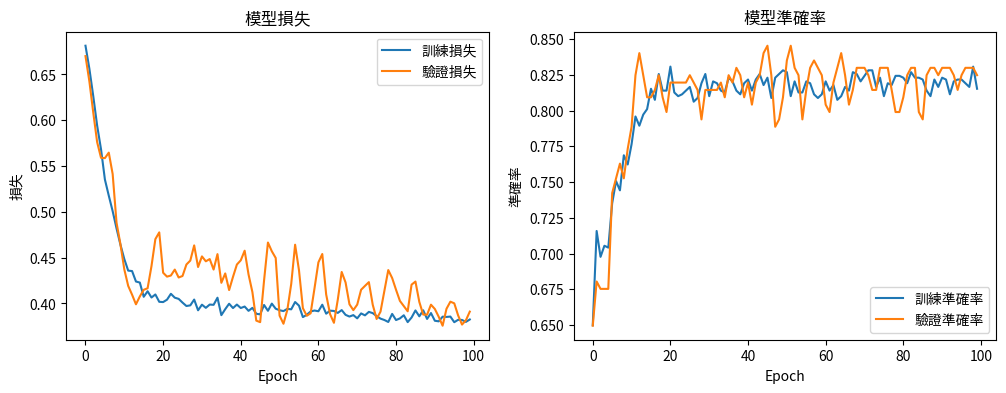

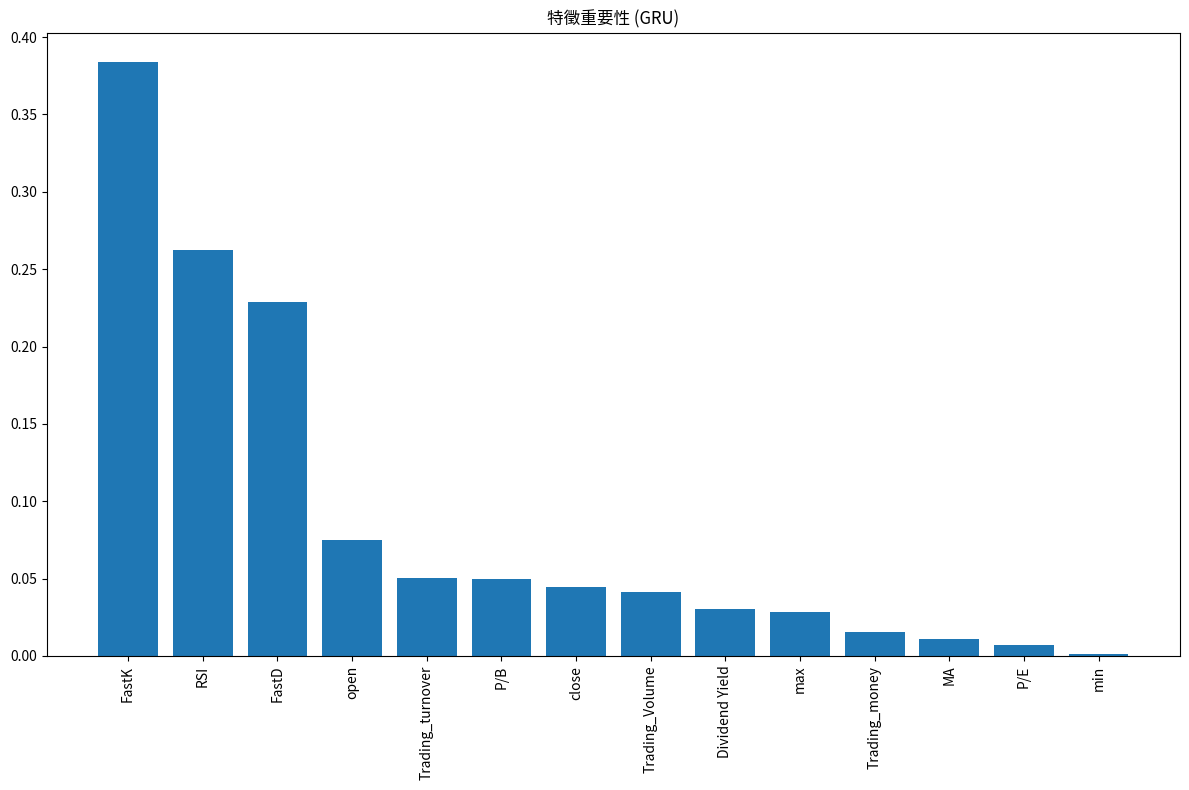

In [ ]:
#基本面+技術面
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','FastK','FastD','RSI','MA','Dividend Yield','P/E','P/B','target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/3711_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

移除欄位: ['spread', 'EPS']
原始數據行數: 1216
刪除缺失值後的行數: 1210
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'RSI', 'MA', 'FastK', 'FastD', 'Dividend Yield',
       'P/E', 'P/B', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,993 (97.63 KB)

 Trainable params: 24,993 (97.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.5656 - loss: 0.6890 - val_accuracy: 0.7113 - val_loss: 0.6722
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6419 - loss: 0.6705 - val_accuracy: 0.7113 - val_loss: 0.6453
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6626 - loss: 0.6513 - val_accuracy: 0.7113 - val_loss: 0.6096
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6742 - loss: 0.6246 - val_accuracy: 0.7165 - val_loss: 0.5788
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6847 - loss: 0.5958 - val_accuracy: 0.7062 - val_loss: 0.5538
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7036 - loss: 0.5669 - val_accuracy: 0.7010 - val_loss: 0.5325
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7450 - loss: 0.5489 - val_accuracy: 0.7268 - val_loss: 0.5211
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7443 - loss: 0.5342 - val_accuracy: 0.7

(<Sequential name=sequential, built=True>, MinMaxScaler())

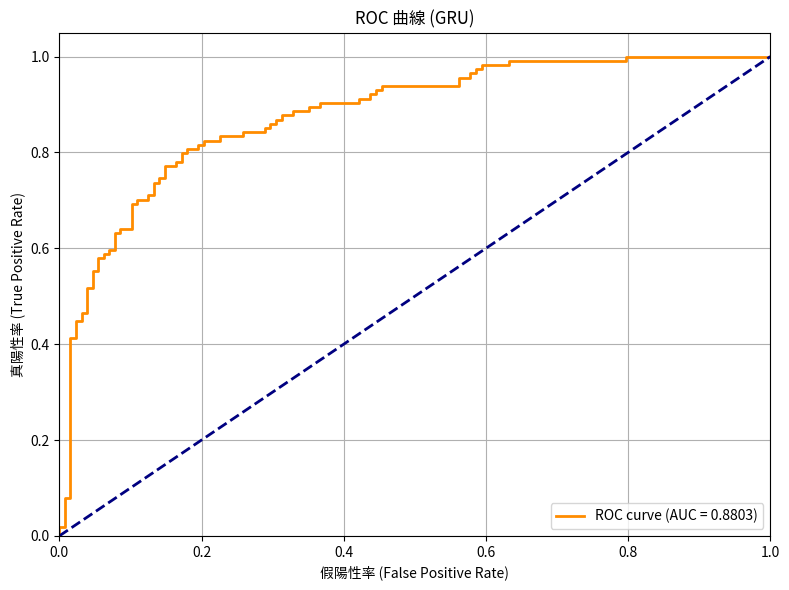

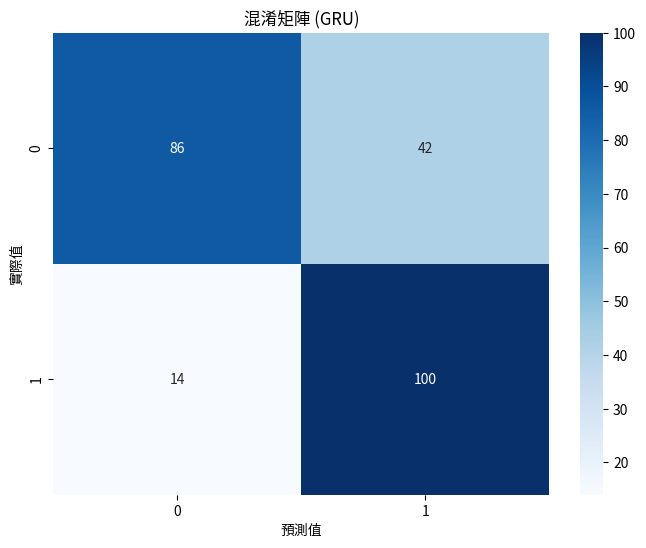

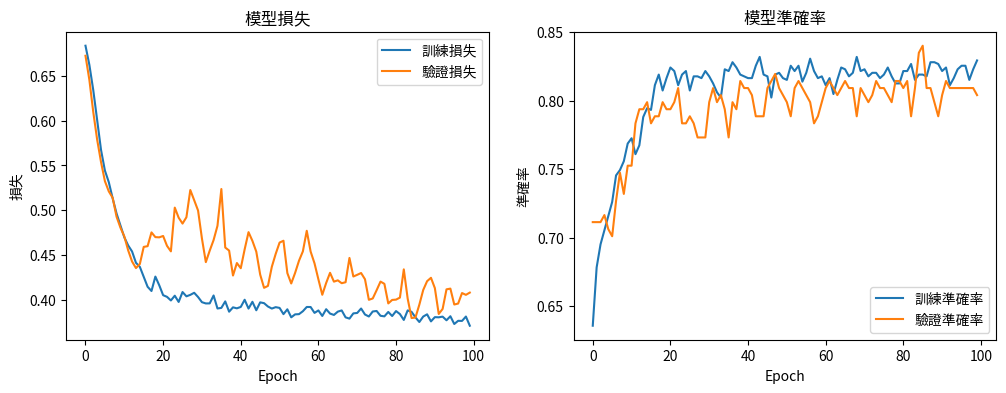

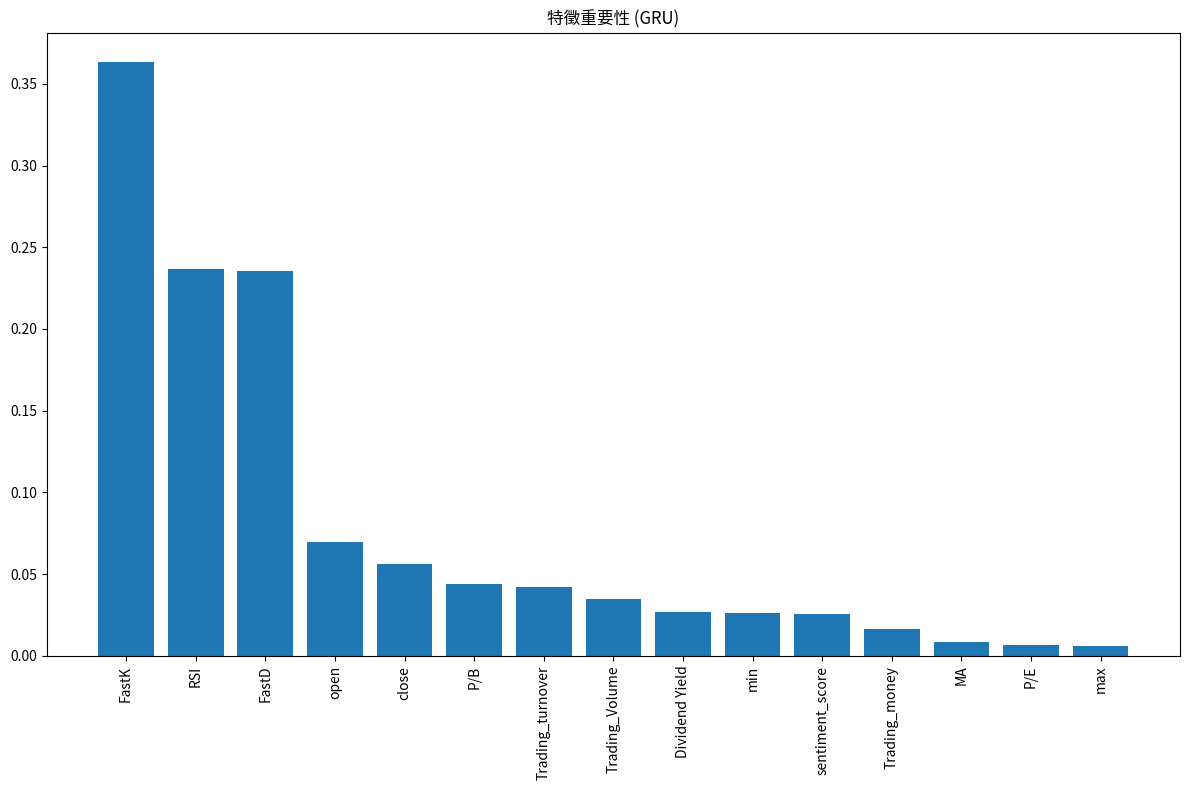

In [ ]:
#3711(他的早停法要放大，不然跑不好)
drop_columns = ['spread','EPS']
main('/content/drive/MyDrive/Regularization/FinGPT Final/3711_summary_sentiment_FinGPT.csv', model_type='gru', epochs=100, batch_size=32, drop_columns=drop_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1210
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,225 (94.63 KB)

 Trainable params: 24,225 (94.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.5056 - loss: 0.6882 - val_accuracy: 0.5000 - val_loss: 0.6768
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5792 - loss: 0.6656 - val_accuracy: 0.7113 - val_loss: 0.6459
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6313 - loss: 0.6436 - val_accuracy: 0.7423 - val_loss: 0.6073
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.6602 - loss: 0.6183 - val_accuracy: 0.7423 - val_loss: 0.5714
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6840 - loss: 0.5991 - val_accuracy: 0.7526 - val_loss: 0.5331
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7299 - loss: 0.5615 - val_accuracy: 0.7577 - val_loss: 0.4888
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7565 - loss: 0.5220 - val_accuracy: 0.7629 - val_loss: 0.4510
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7731 - loss: 0.4845 - val_accuracy: 0.7

(<Sequential name=sequential, built=True>, MinMaxScaler())

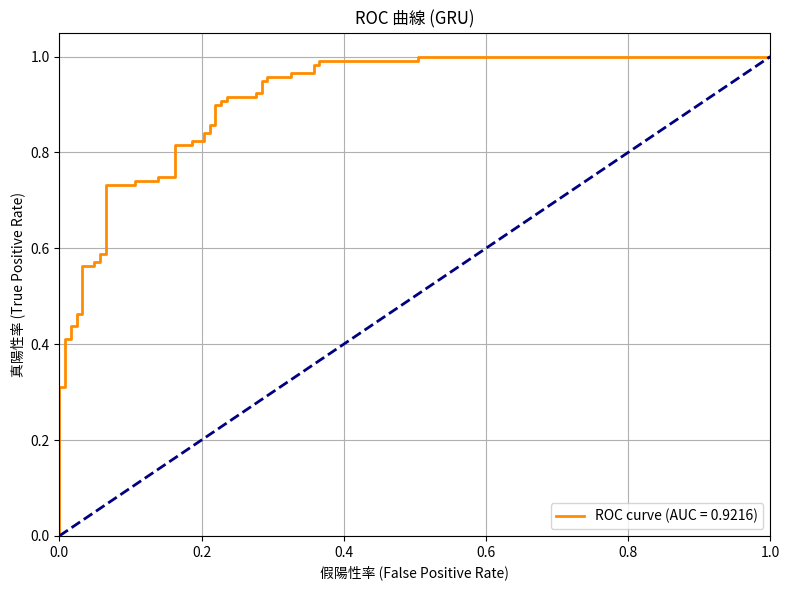

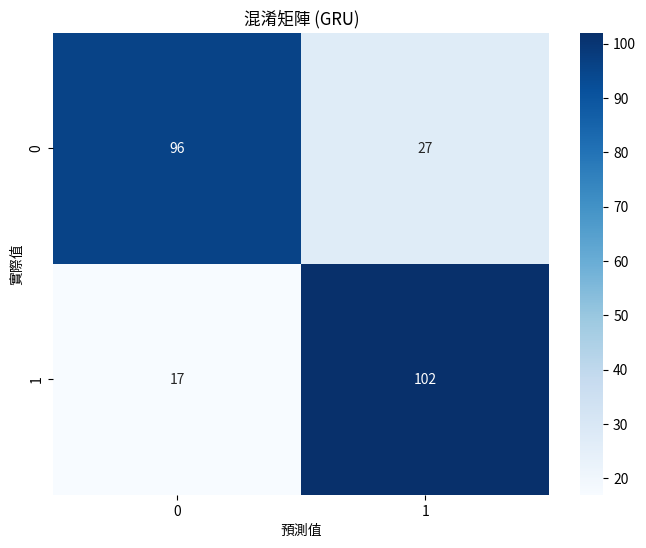

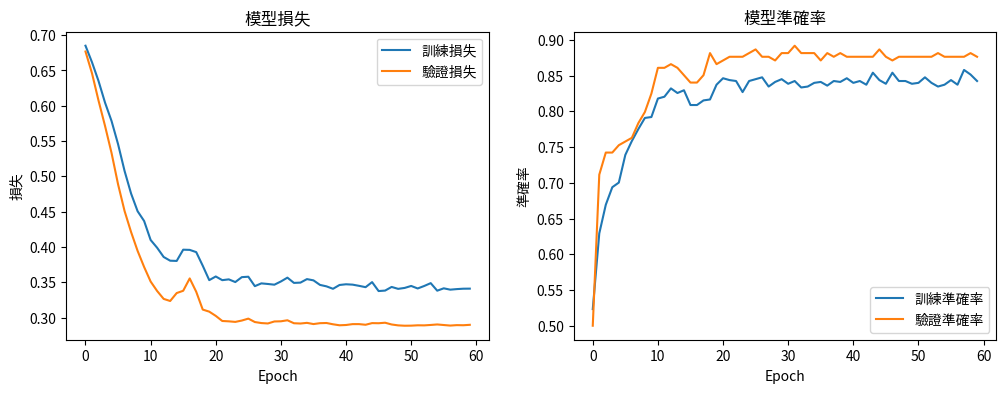

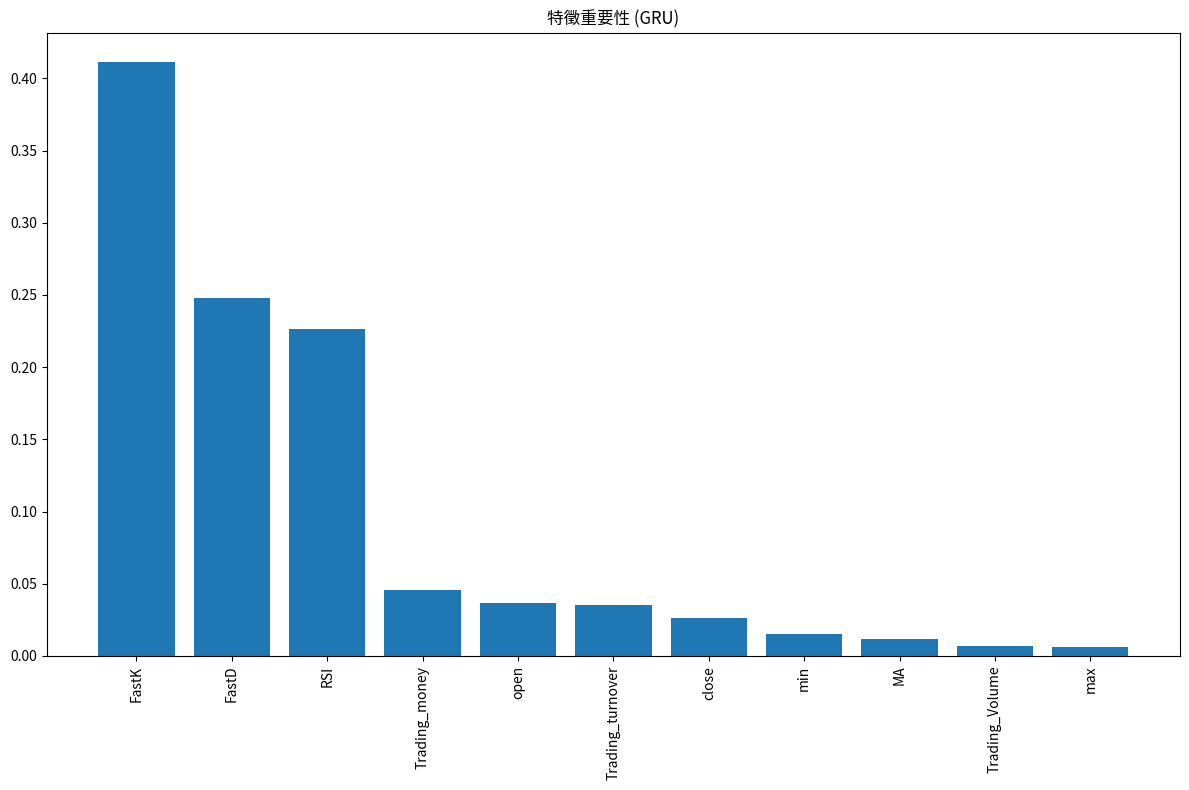

In [ ]:
# 技術(baseline)🙅‍♀️
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','FastK','FastD','RSI','MA','target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/2379_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1210
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,417 (95.38 KB)

 Trainable params: 24,417 (95.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.5367 - loss: 0.6871 - val_accuracy: 0.5979 - val_loss: 0.6743
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5961 - loss: 0.6692 - val_accuracy: 0.7320 - val_loss: 0.6445
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6140 - loss: 0.6520 - val_accuracy: 0.7577 - val_loss: 0.6091
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6395 - loss: 0.6273 - val_accuracy: 0.7577 - val_loss: 0.5700
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6741 - loss: 0.6072 - val_accuracy: 0.7577 - val_loss: 0.5413
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7042 - loss: 0.5826 - val_accuracy: 0.7629 - val_loss: 0.5066
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7380 - loss: 0.5513 - val_accuracy: 0.7887 - val_loss: 0.4725
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7526 - loss: 0.5134 - val_accuracy: 0.7732 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

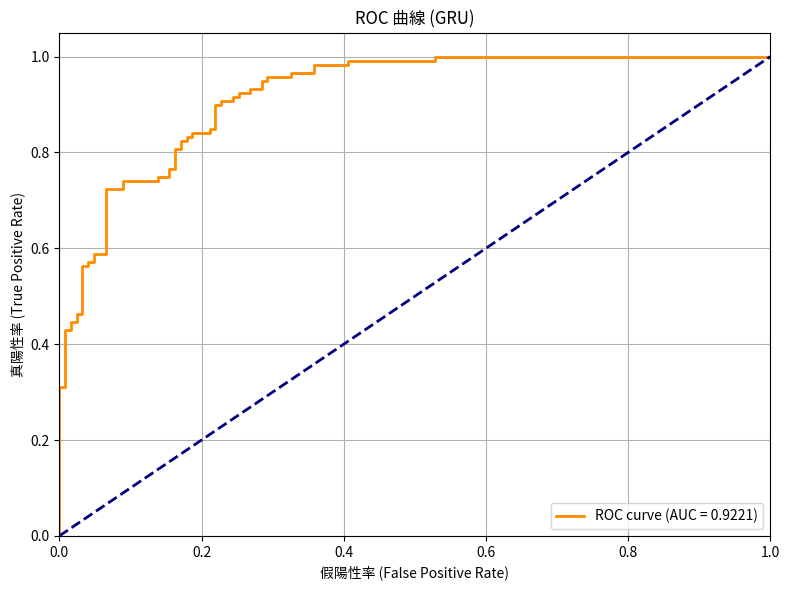

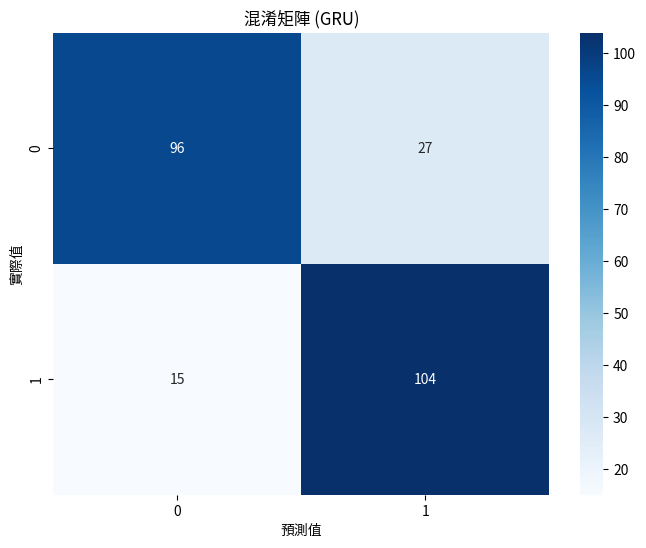

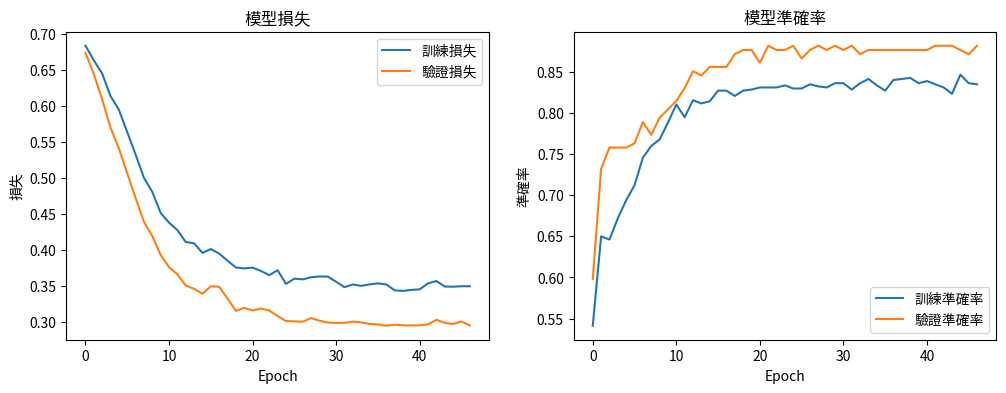

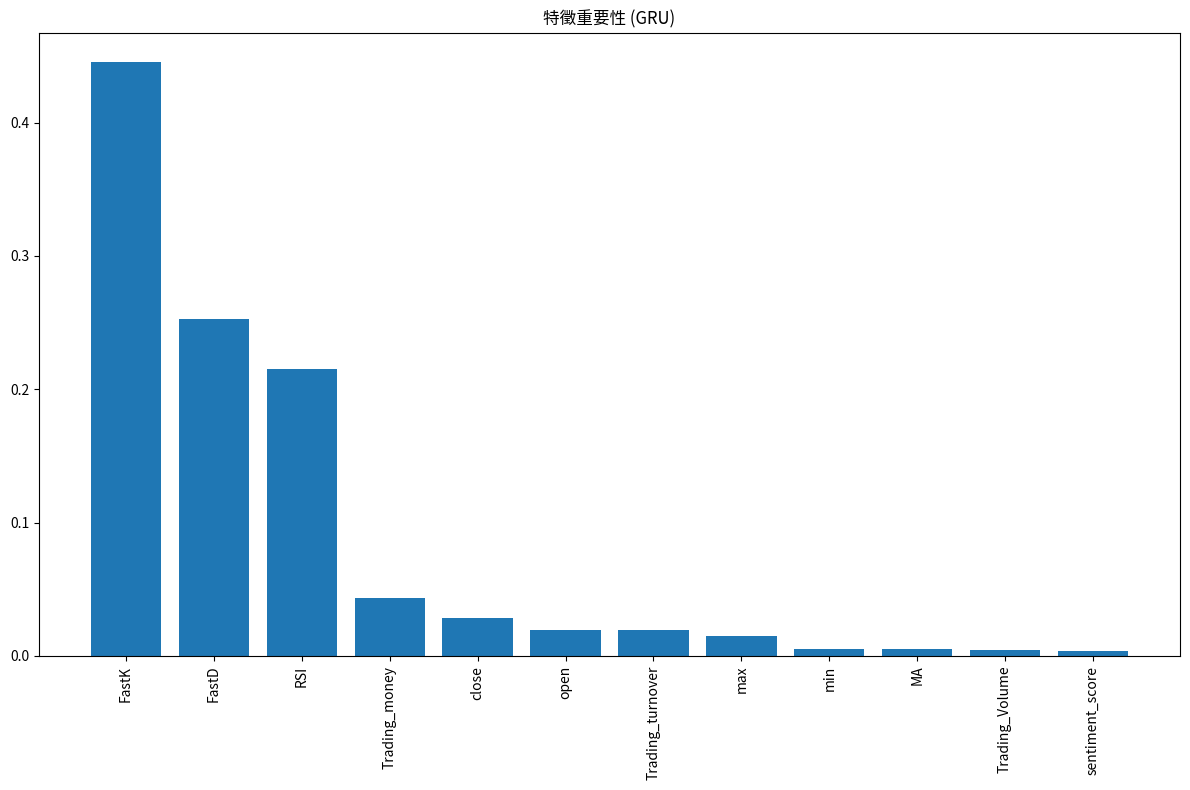

In [ ]:
# 技術+消息🙅‍♀️
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','FastK','FastD','RSI','MA','sentiment_score','target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/2379_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'Dividend Yield', 'P/E', 'P/B', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1210
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'Dividend Yield',
       'P/E', 'P/B'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        15,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801 (96.88 KB)

 Trainable params: 24,801 (96.88 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6069 - loss: 0.6871 - val_accuracy: 0.6598 - val_loss: 0.6748
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6552 - loss: 0.6697 - val_accuracy: 0.6856 - val_loss: 0.6538
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6614 - loss: 0.6477 - val_accuracy: 0.6856 - val_loss: 0.6253
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6821 - loss: 0.6172 - val_accuracy: 0.7010 - val_loss: 0.6027
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6891 - loss: 0.5874 - val_accuracy: 0.7165 - val_loss: 0.5746
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7244 - loss: 0.5584 - val_accuracy: 0.7010 - val_loss: 0.5429
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7483 - loss: 0.5405 - val_accuracy: 0.7062 - val_loss: 0.5237
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7304 - loss: 0.5178 - val_accuracy: 0.7165

(<Sequential name=sequential, built=True>, MinMaxScaler())

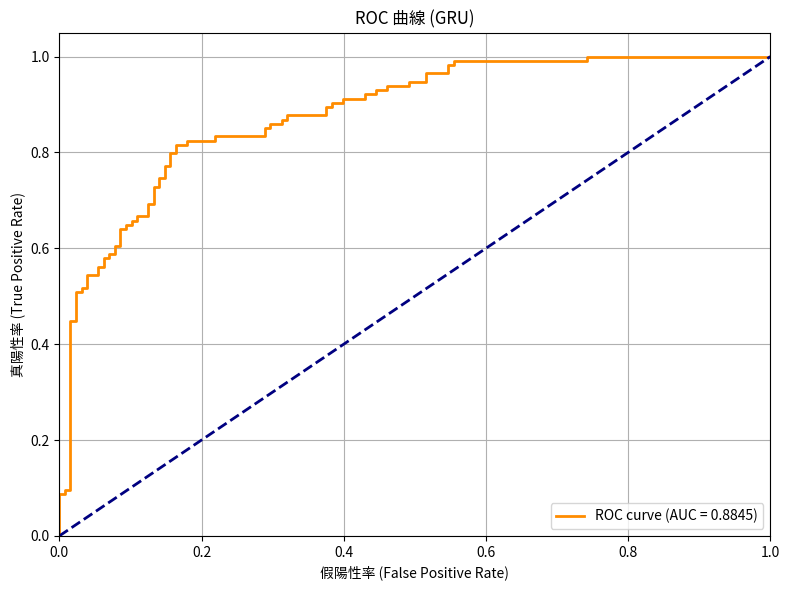

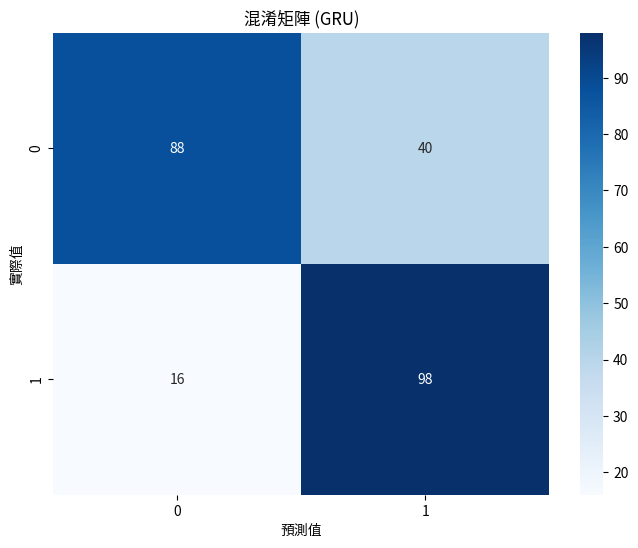

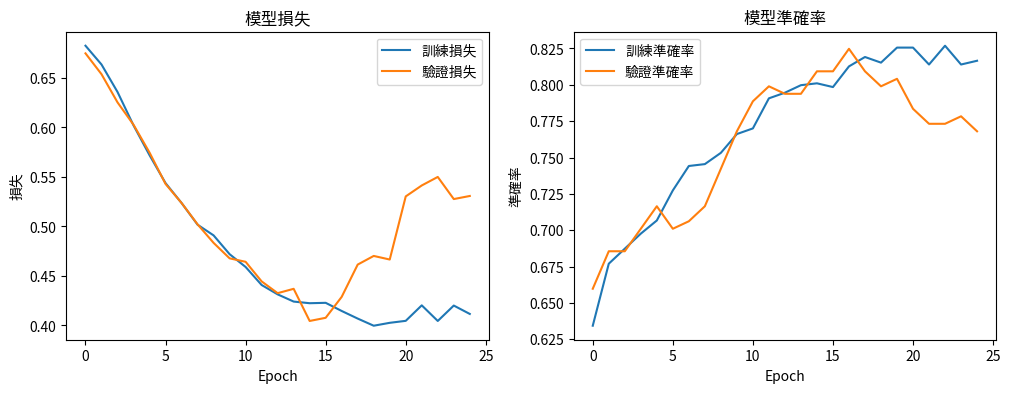

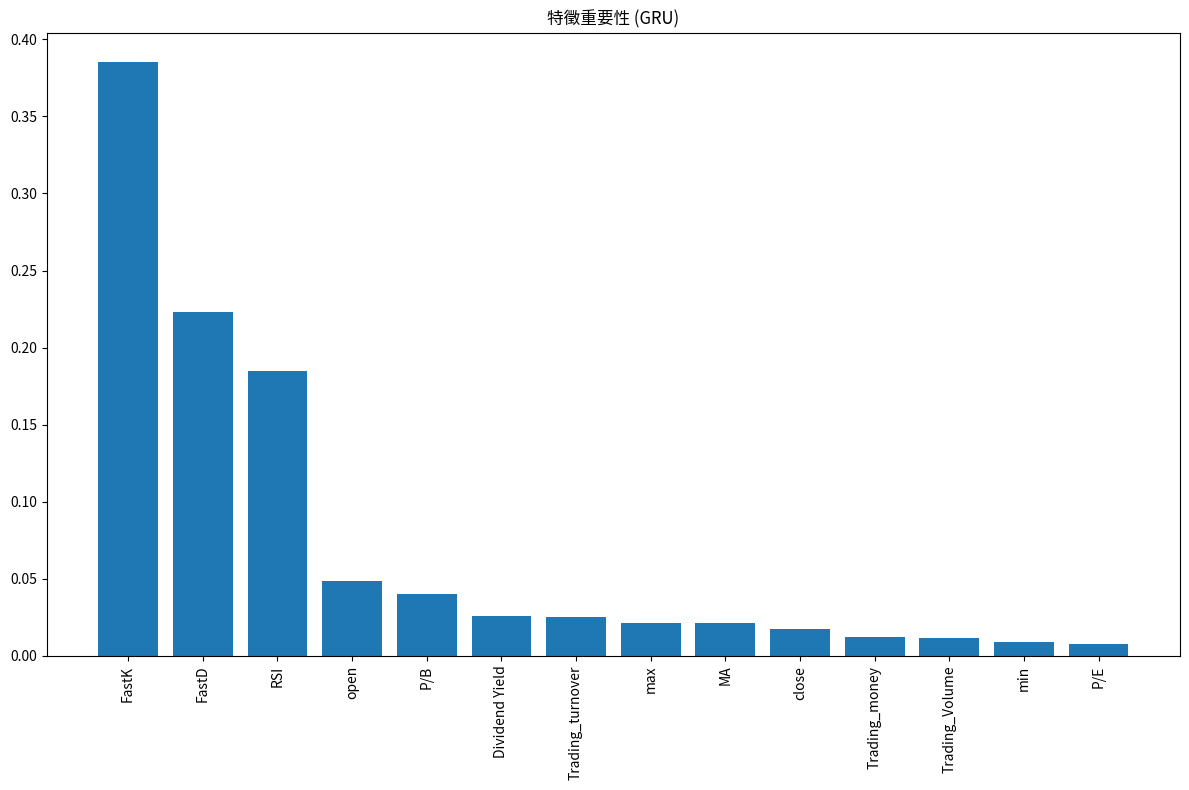

In [ ]:
# 技術+基本👌
select_columns = ['date','stock_id','Trading_Volume','Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','FastK','FastD','RSI','MA','Dividend Yield','P/E','P/B','target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/3711_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)

In [ ]:
# 執行程式時傳入要排除的欄位名稱→要把漲跌幅拿掉，因為漲跌幅+/-會影響到，怕提前知道答案
drop_columns = ['spread']  # 要排除的欄位名稱
main("/content/drive/MyDrive/Regularization/FinGPT Final/3711_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, drop_columns=drop_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

移除欄位: ['spread']
原始數據行數: 1216
刪除缺失值後的行數: 0
刪除了 1216 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'RSI', 'MA', 'FastK', 'FastD', 'Dividend Yield',
       'P/E', 'P/B', 'sentiment_score', 'EPS'],
      dtype='object')
執行中發生錯誤: Found array with 0 sample(s) (shape=(0, 16)) while a minimum of 1 is required by MinMaxScaler.


Traceback (most recent call last):
  File "<ipython-input-3-454e6f6b90a5>", line 252, in main
    X, y, scaler = feature_engineering(df)
                   ^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-3-454e6f6b90a5>", line 62, in feature_engineering
    scaled_features = scaler.fit_transform(features)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 319, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 918, in fit_transform
    return self.fit(X, **fit_params).transform(X)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py", line 447, in fit
    return self.partial_fit(X, y)
           ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fi

(None, None)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'sentiment_score', 'target']
原始數據行數: 1179
刪除缺失值後的行數: 1173
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'FastK', 'FastD', 'RSI', 'MA', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,417 (95.38 KB)

 Trainable params: 24,417 (95.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.5169 - loss: 0.6882 - val_accuracy: 0.6809 - val_loss: 0.6709
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5960 - loss: 0.6698 - val_accuracy: 0.7872 - val_loss: 0.6348
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6608 - loss: 0.6445 - val_accuracy: 0.7872 - val_loss: 0.5822
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6656 - loss: 0.6208 - val_accuracy: 0.7819 - val_loss: 0.5299
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7119 - loss: 0.5869 - val_accuracy: 0.7713 - val_loss: 0.4905
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7184 - loss: 0.5544 - val_accuracy: 0.7713 - val_loss: 0.4655
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7302 - loss: 0.5234 - val_accuracy: 0.7819 - val_loss: 0.4618
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7554 - loss: 0.5020 - val_accuracy: 0.7766 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

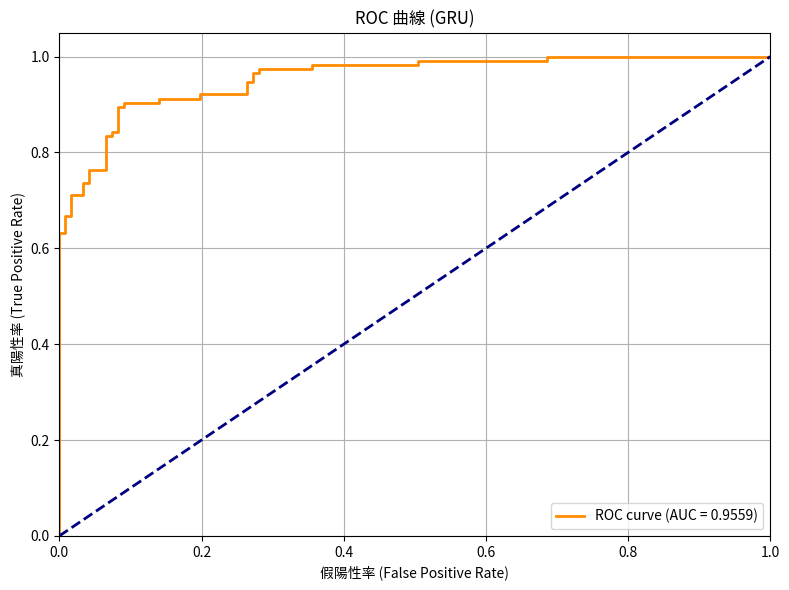

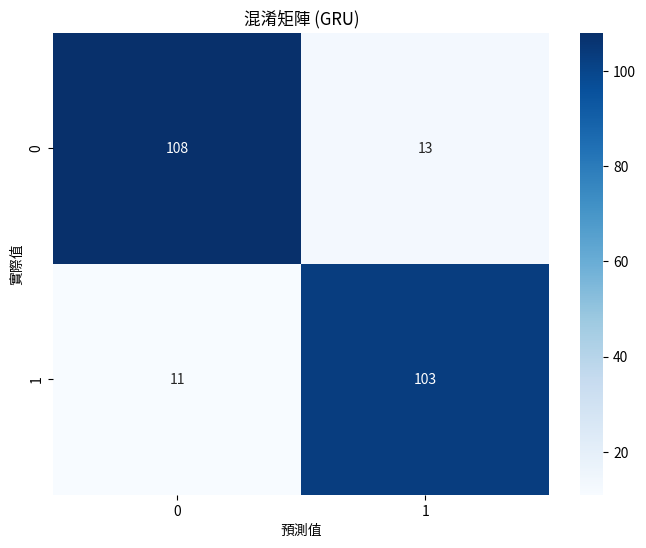

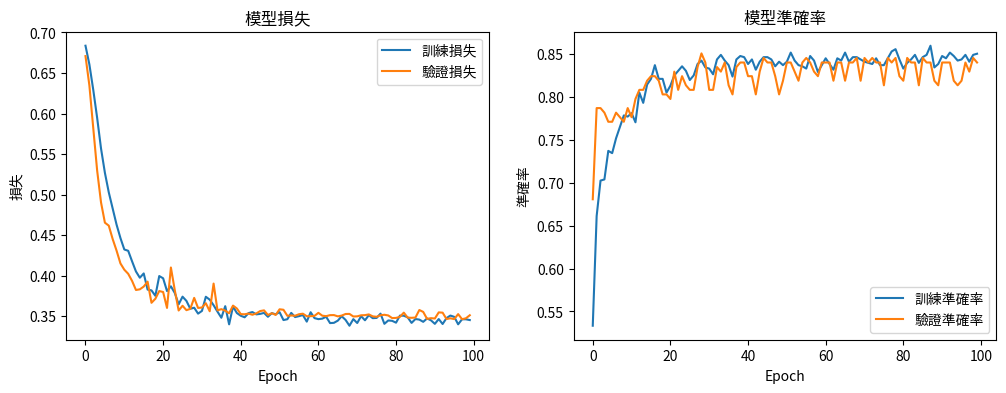

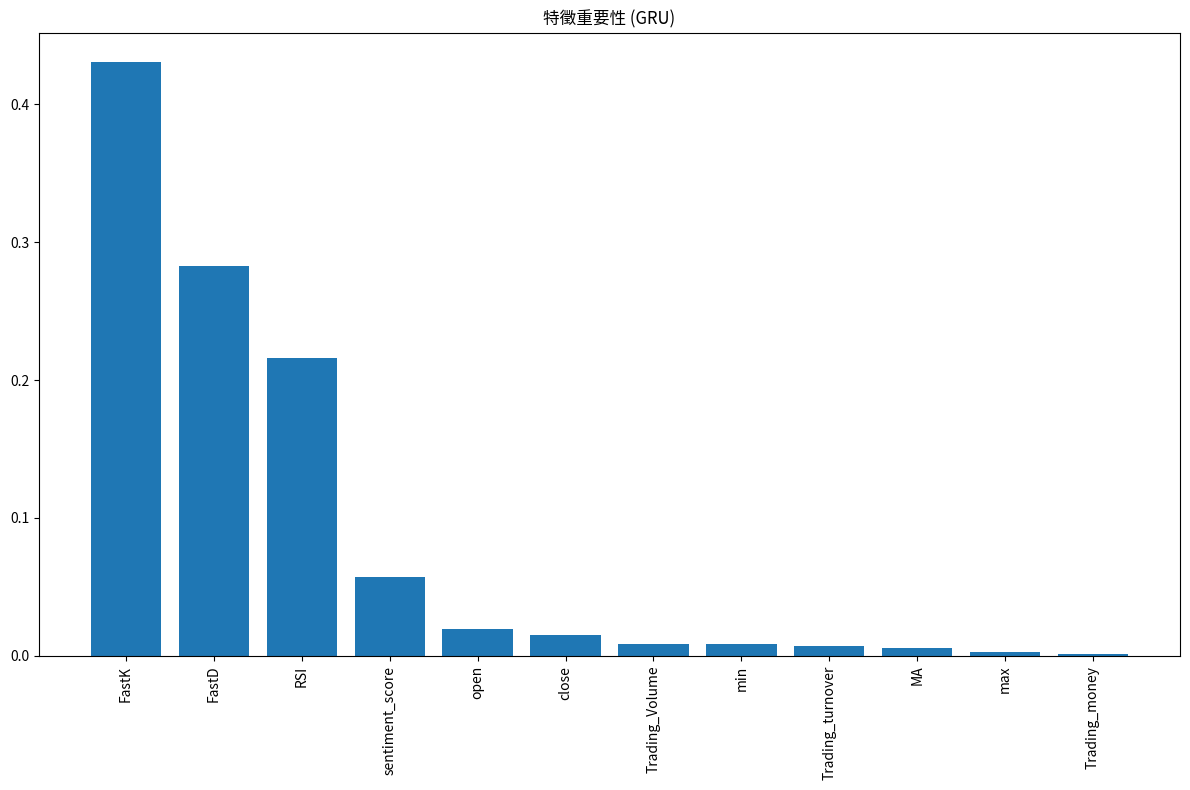

In [ ]:
# 技術+消息🧐💟
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','FastK','FastD','RSI','MA','sentiment_score','target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/2303_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)

# 模型比較


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5149 - loss: 0.6921 - val_accuracy: 0.4872 - val_loss: 0.6946
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5422 - loss: 0.6894 - val_accuracy: 0.4872 - val_loss: 0.6946
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5422 - loss: 0.6880 - val_accuracy: 0.4872 - val_loss: 0.6943
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5450 - loss: 0.6864 - val_accuracy: 0.4872 - val_loss: 0.6936
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5472 - loss: 0.6857 - val_accuracy: 0.4923 - val_loss: 0.6932
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5544 - loss: 0.6822 - val_accuracy: 0.4821 - val_loss: 0.6927
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5533 - loss: 0.6820 - val_accuracy: 0.4923 - val_loss: 0.6915
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5465 - loss: 0.6827 - val_accuracy: 0.5

(<Sequential name=sequential, built=True>, MinMaxScaler())

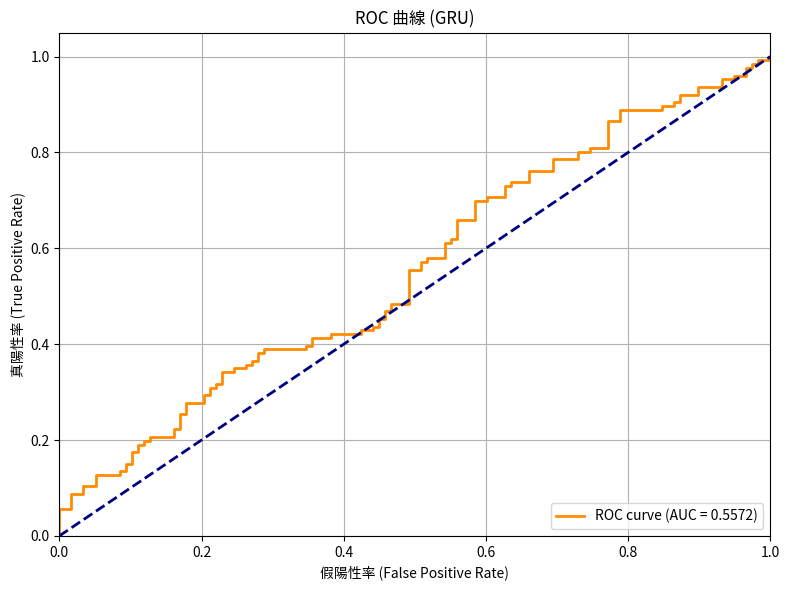

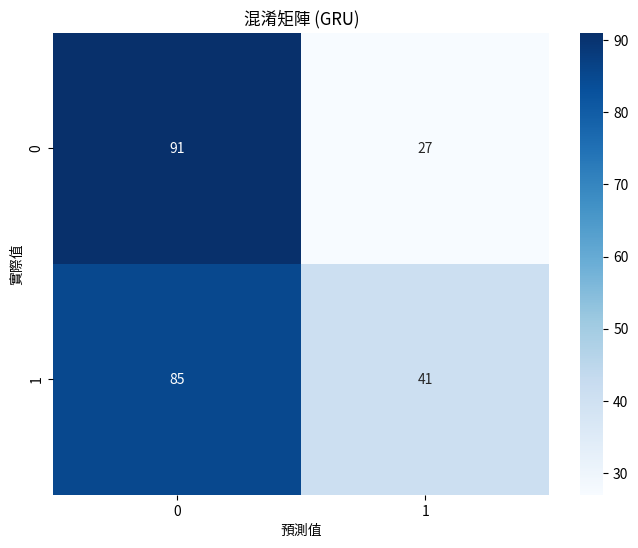

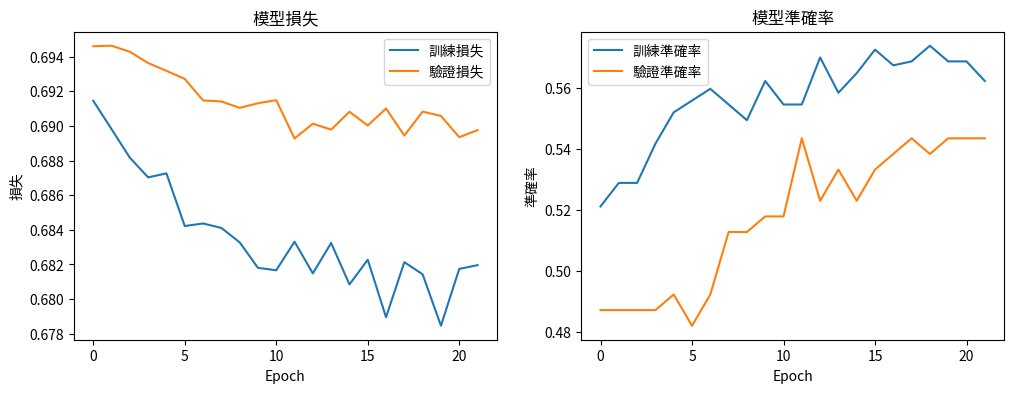

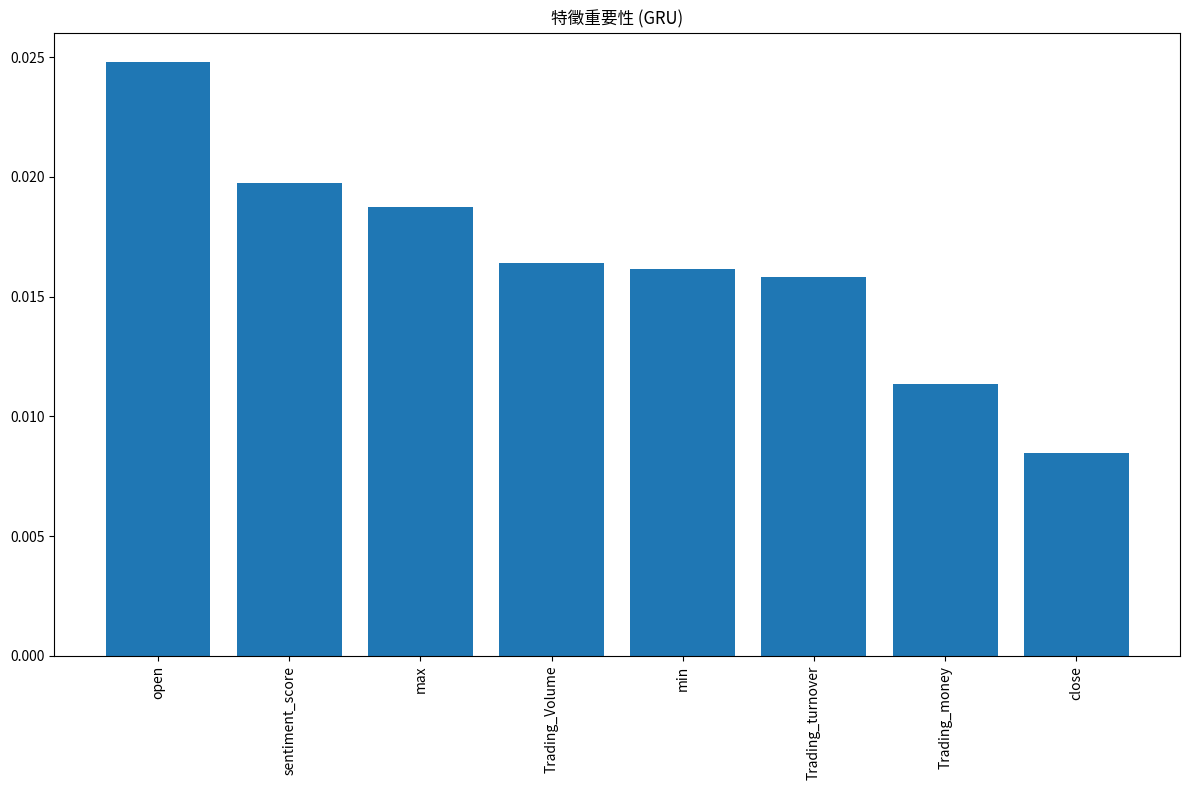

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/final-fivedays/3771_title_sentiment_FinGPT_5.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5276 - loss: 0.6918 - val_accuracy: 0.6667 - val_loss: 0.6838
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5340 - loss: 0.6889 - val_accuracy: 0.6821 - val_loss: 0.6722
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5638 - loss: 0.6862 - val_accuracy: 0.6718 - val_loss: 0.6590
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5736 - loss: 0.6820 - val_accuracy: 0.6872 - val_loss: 0.6450
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5690 - loss: 0.6816 - val_accuracy: 0.6667 - val_loss: 0.6315
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5583 - loss: 0.6869 - val_accuracy: 0.6718 - val_loss: 0.6263
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5486 - loss: 0.6878 - val_accuracy: 0.6667 - val_loss: 0.6231
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5381 - loss: 0.6826 - val_accuracy: 0.6769 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

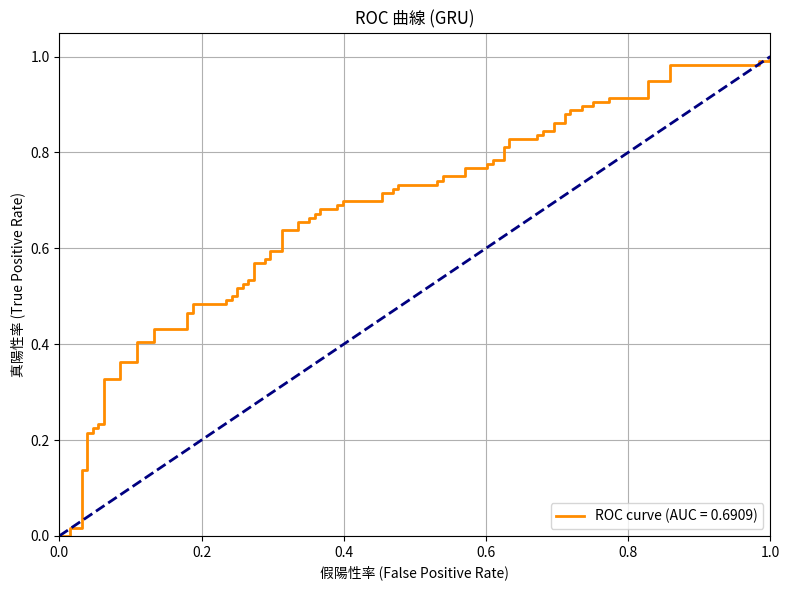

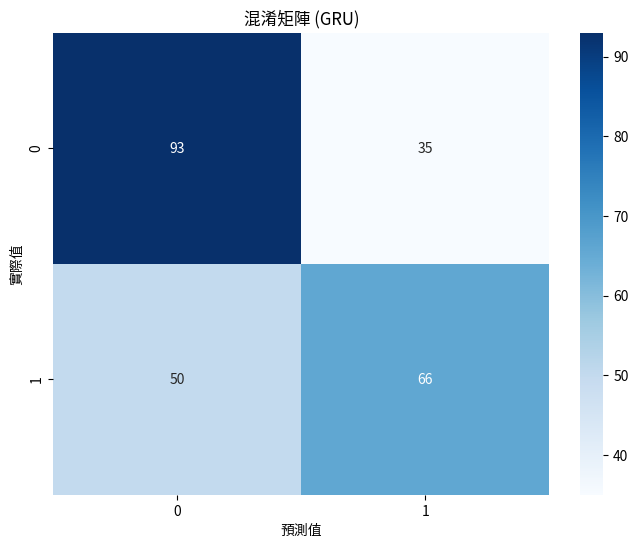

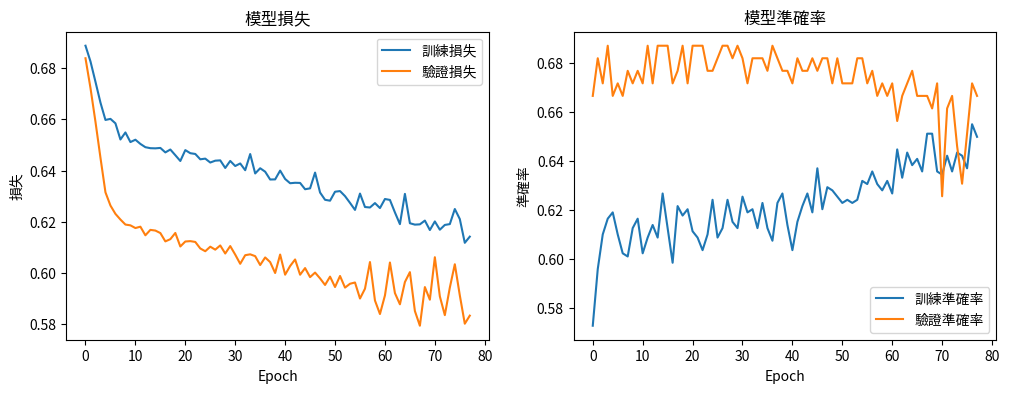

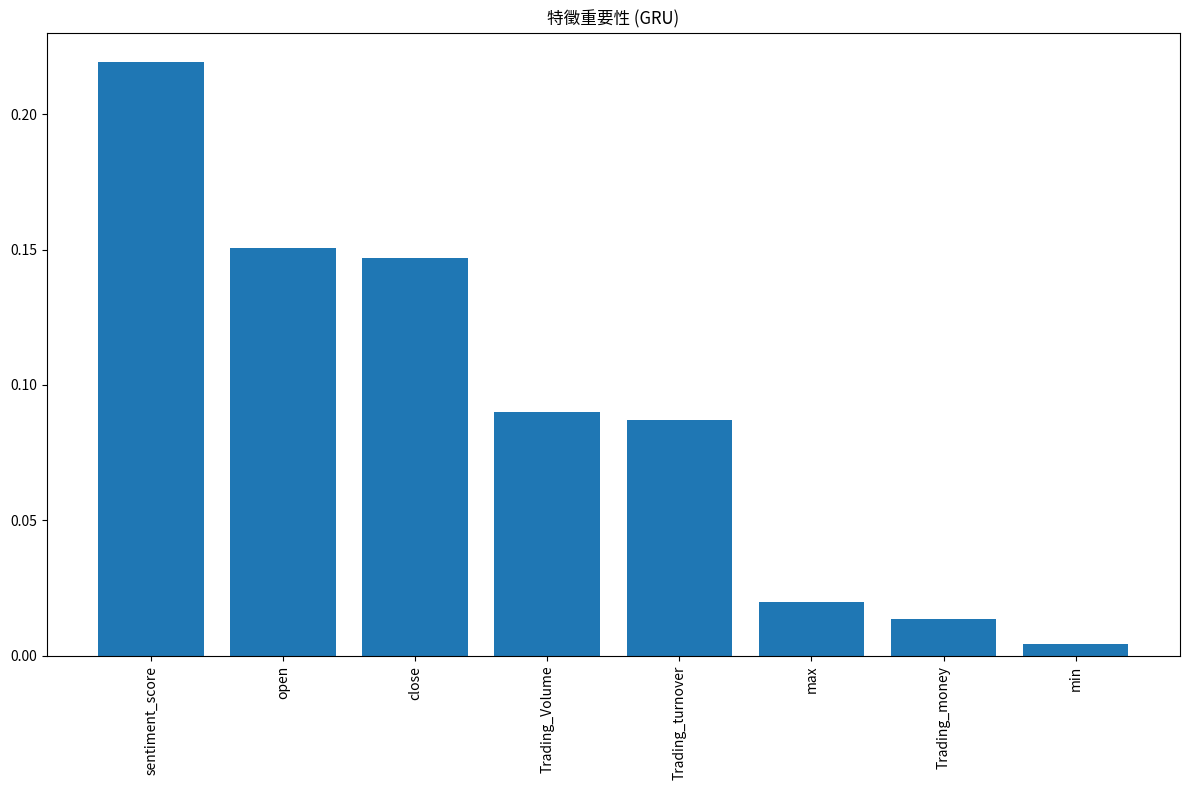

In [ ]:
# 執行程式時傳入要選擇的欄位名稱❤️
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/final-fivedays/3711_summary_sentiment_FinGPT_5.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4931 - loss: 0.6931 - val_accuracy: 0.5128 - val_loss: 0.6874
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5289 - loss: 0.6901 - val_accuracy: 0.6564 - val_loss: 0.6778
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5331 - loss: 0.6863 - val_accuracy: 0.6513 - val_loss: 0.6669
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5439 - loss: 0.6868 - val_accuracy: 0.6667 - val_loss: 0.6552
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5389 - loss: 0.6858 - val_accuracy: 0.6667 - val_loss: 0.6469
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5421 - loss: 0.6901 - val_accuracy: 0.6667 - val_loss: 0.6406
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5416 - loss: 0.6877 - val_accuracy: 0.6718 - val_loss: 0.6360
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5433 - loss: 0.6884 - val_accuracy: 0.6718

(<Sequential name=sequential, built=True>, MinMaxScaler())

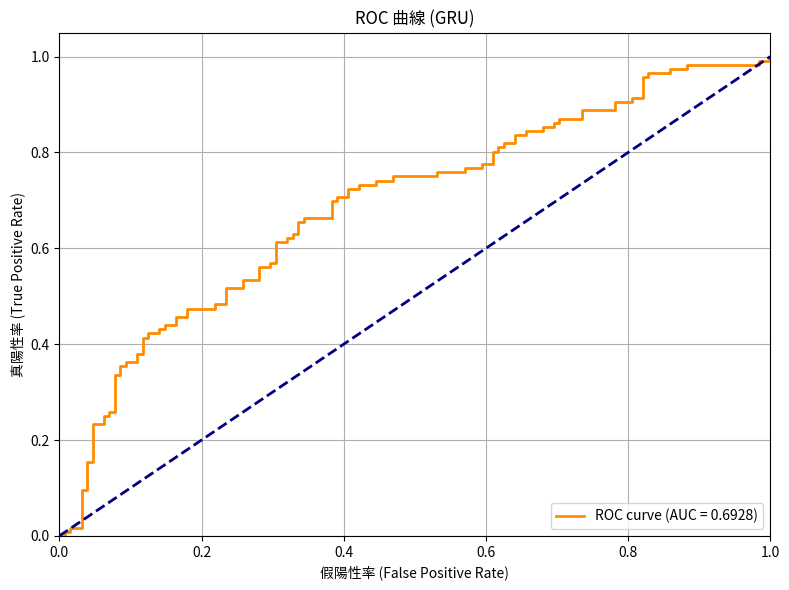

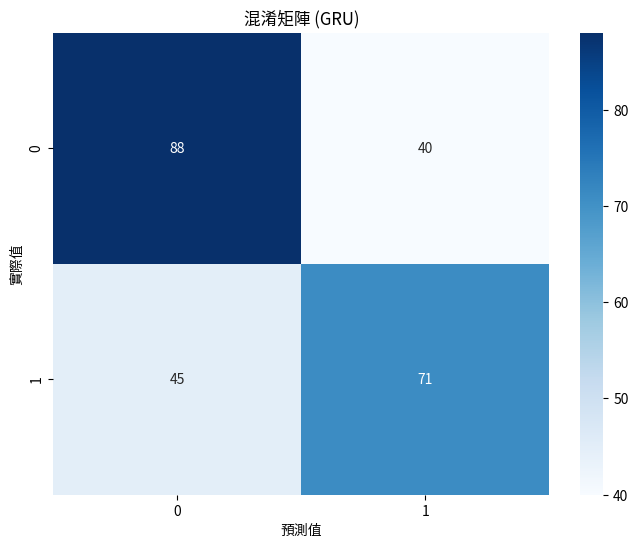

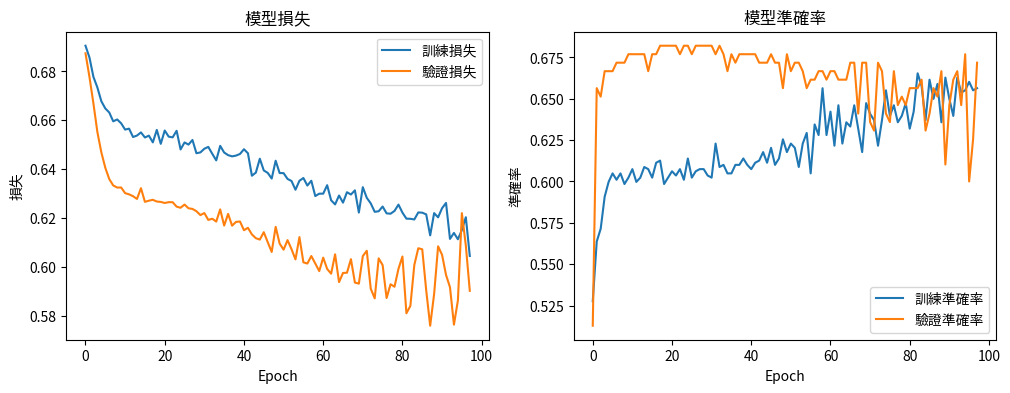

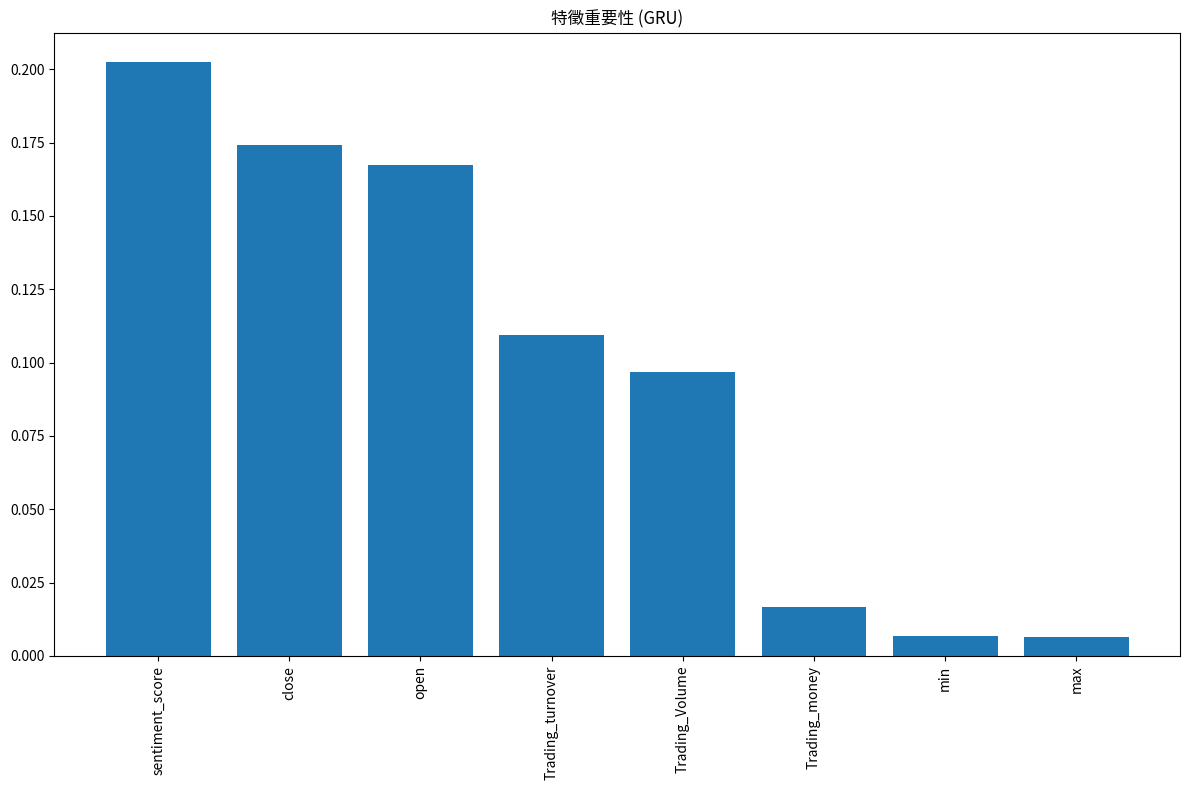

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/3711_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4670 - loss: 0.6940 - val_accuracy: 0.5077 - val_loss: 0.6922
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5262 - loss: 0.6915 - val_accuracy: 0.5026 - val_loss: 0.6899
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5498 - loss: 0.6912 - val_accuracy: 0.5128 - val_loss: 0.6869
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5193 - loss: 0.6912 - val_accuracy: 0.5231 - val_loss: 0.6834
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5619 - loss: 0.6896 - val_accuracy: 0.5590 - val_loss: 0.6789
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5109 - loss: 0.6901 - val_accuracy: 0.6462 - val_loss: 0.6727
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5443 - loss: 0.6880 - val_accuracy: 0.6410 - val_loss: 0.6661
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5493 - loss: 0.6854 - val_accuracy: 0.65

(<Sequential name=sequential, built=True>, MinMaxScaler())

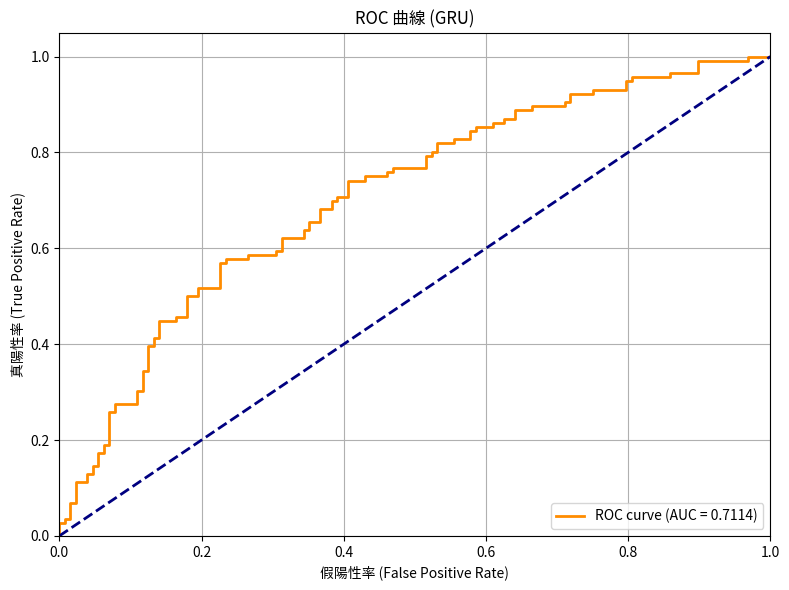

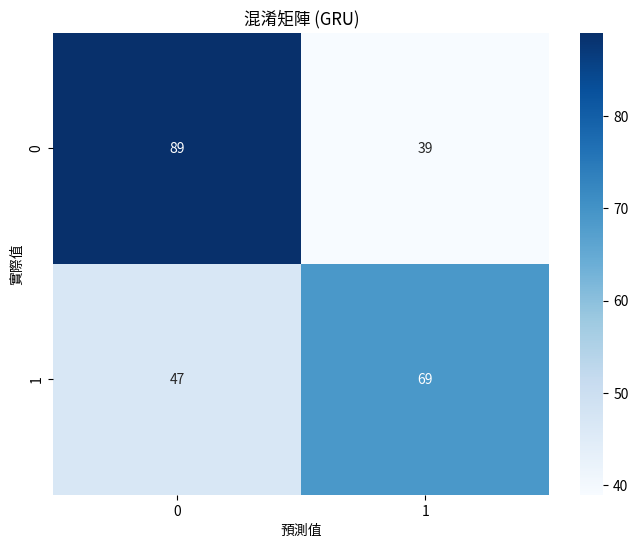

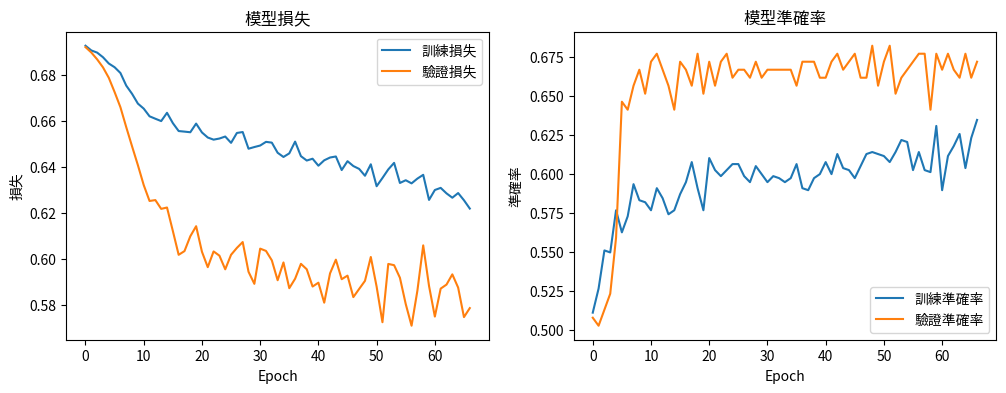

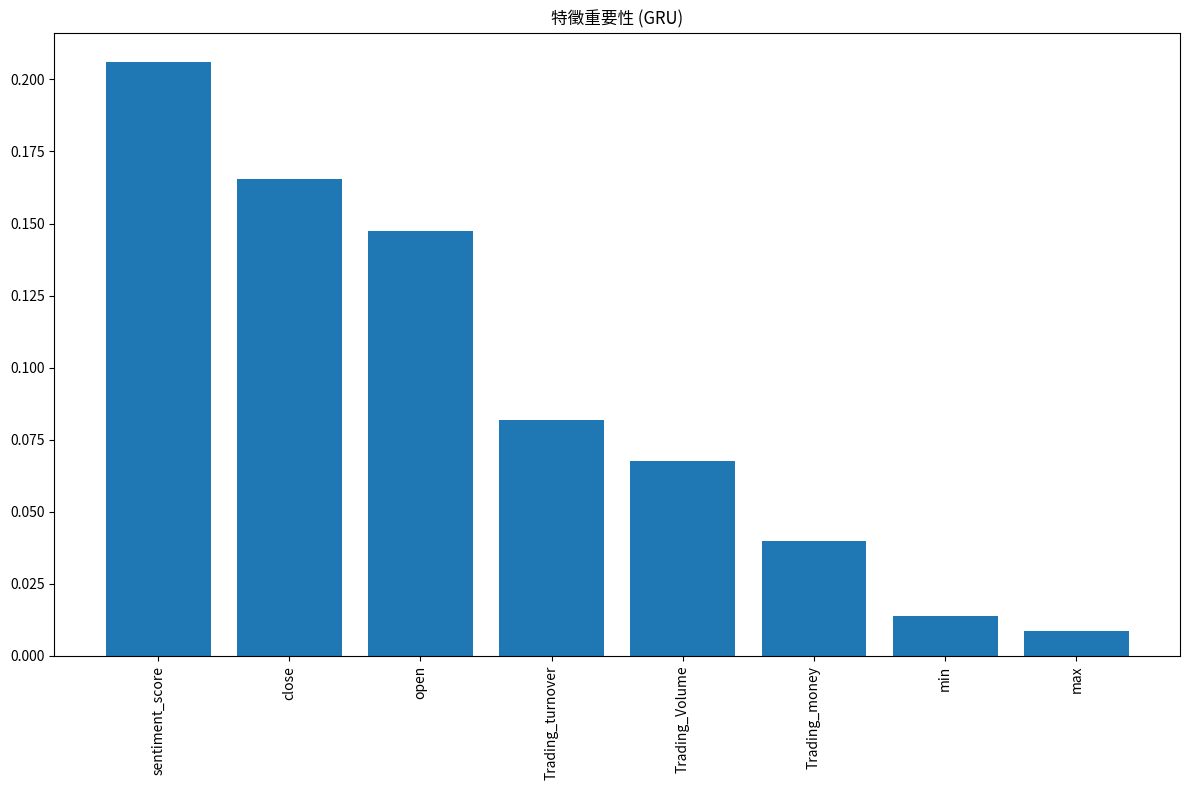

In [ ]:
# 執行程式時傳入要選擇的欄位名稱❤️
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/BERT Final/3711_stock_summary(1)_sentiment.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)

# 3661


=== 使用 LSTM 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5021 - loss: 0.6929 - val_accuracy: 0.4872 - val_loss: 0.6937
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5422 - loss: 0.6911 - val_accuracy: 0.4872 - val_loss: 0.6941
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6894 - val_accuracy: 0.4872 - val_loss: 0.6945
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6883 - val_accuracy: 0.4872 - val_loss: 0.6950
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6869 - val_accuracy: 0.4872 - val_loss: 0.6954
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5422 - loss: 0.6850 - val_accuracy: 0.4872 - val_loss: 0.6957
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5433 - loss: 0.6845 - val_accuracy: 0.4872 - val_loss: 0.6948
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5447 - loss: 0.6833 - val_accuracy: 0.4872 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

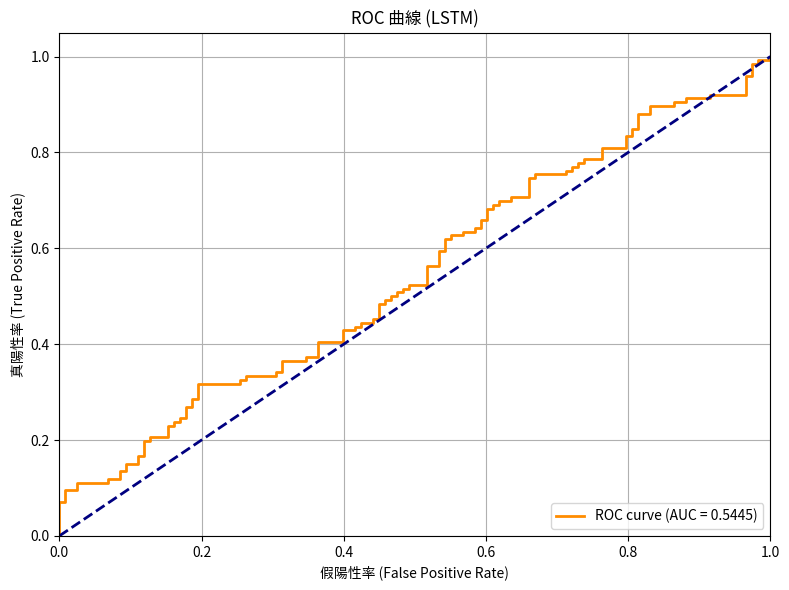

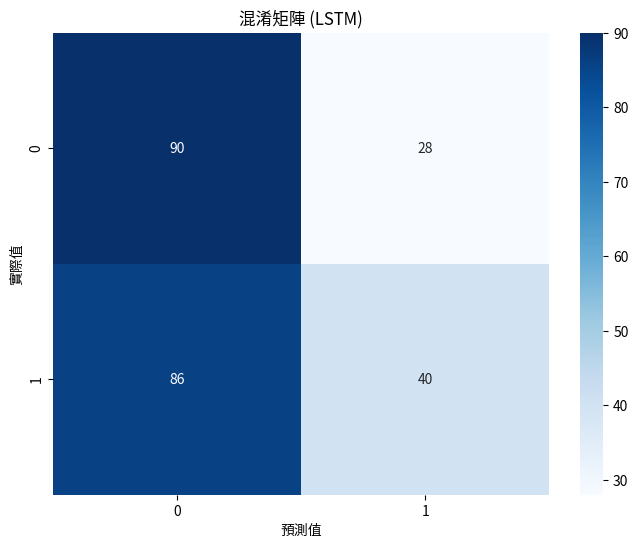

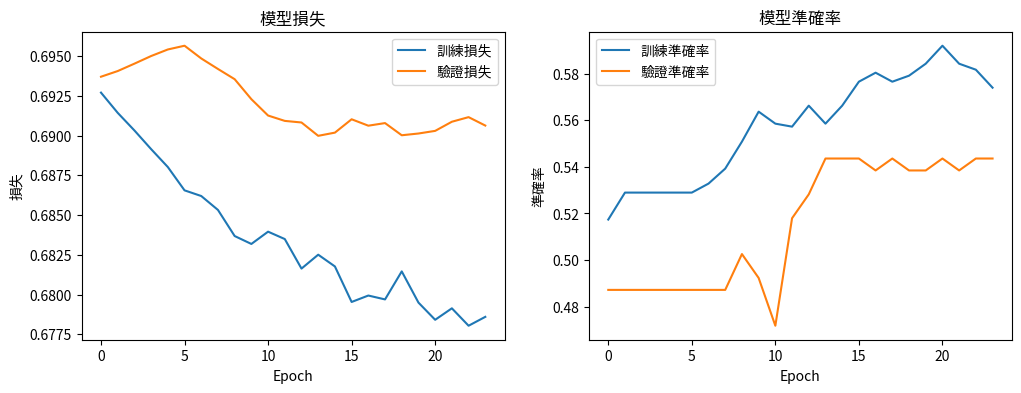

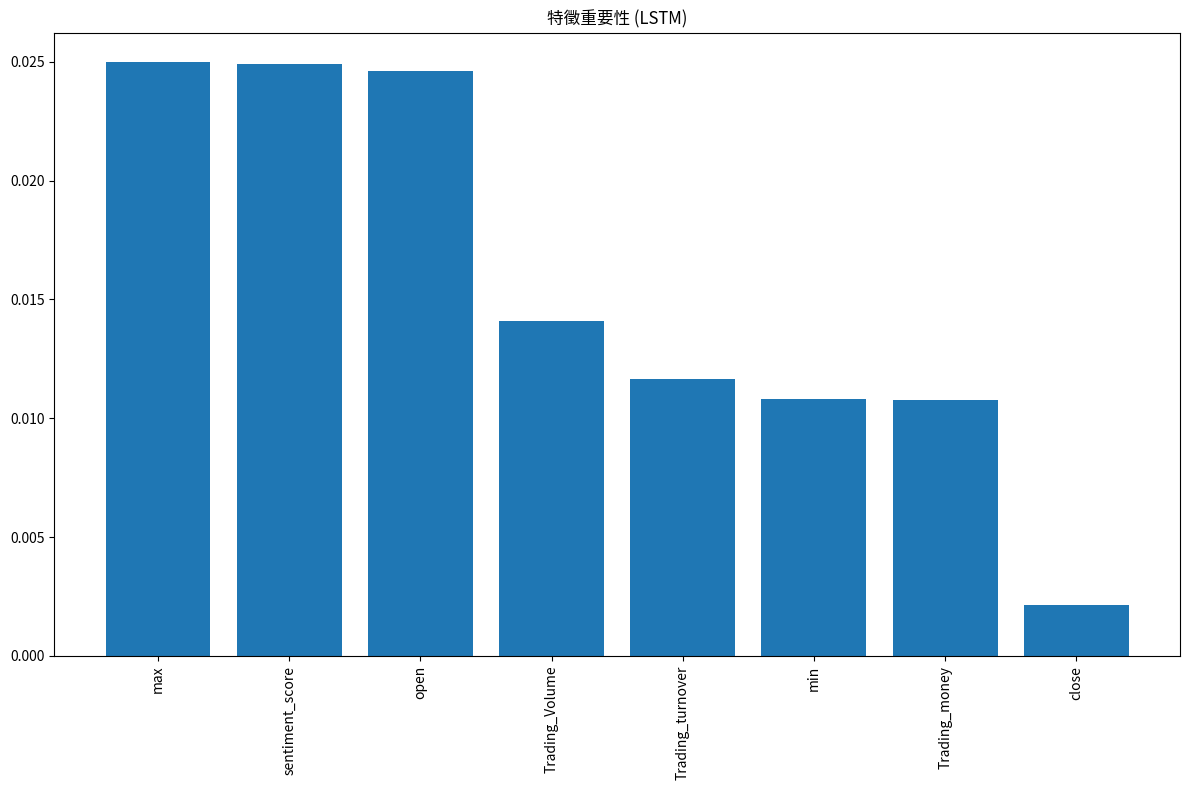

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/BERT/3661_stock_title_sentiment_5.csv", model_type='lstm', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 LSTM 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.5376 - loss: 0.6926 - val_accuracy: 0.4872 - val_loss: 0.6936
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6910 - val_accuracy: 0.4872 - val_loss: 0.6939
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6896 - val_accuracy: 0.4872 - val_loss: 0.6944
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6882 - val_accuracy: 0.4872 - val_loss: 0.6949
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6875 - val_accuracy: 0.4872 - val_loss: 0.6950
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6861 - val_accuracy: 0.4872 - val_loss: 0.6950
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6858 - val_accuracy: 0.4872 - val_loss: 0.6945
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5460 - loss: 0.6842 - val_accuracy: 0.4872 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

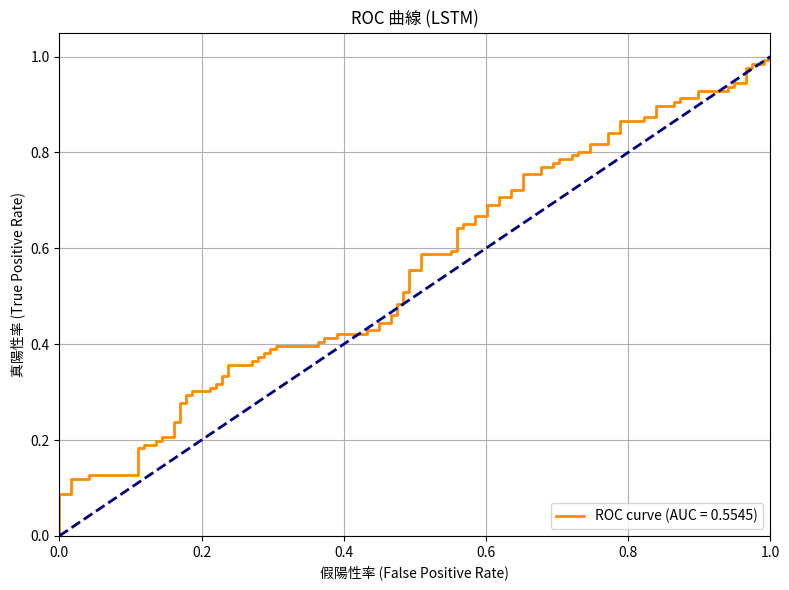

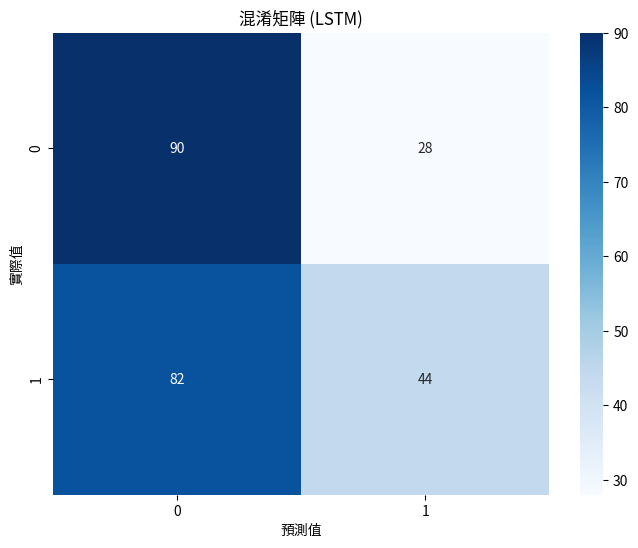

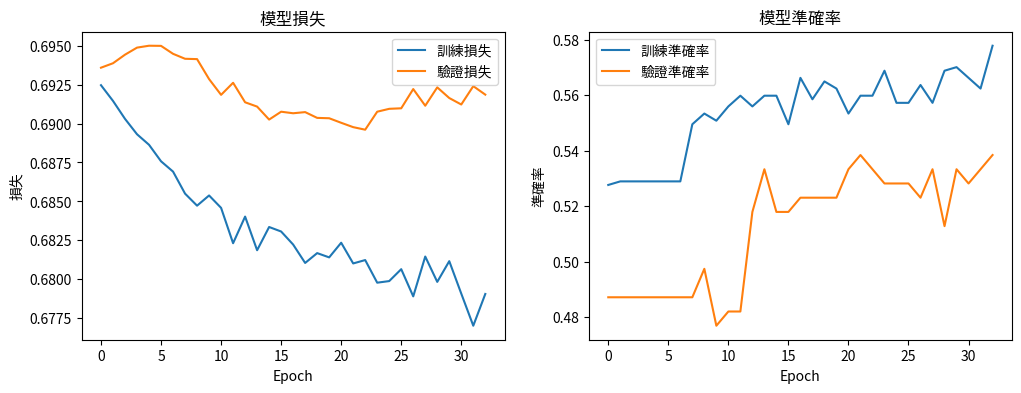

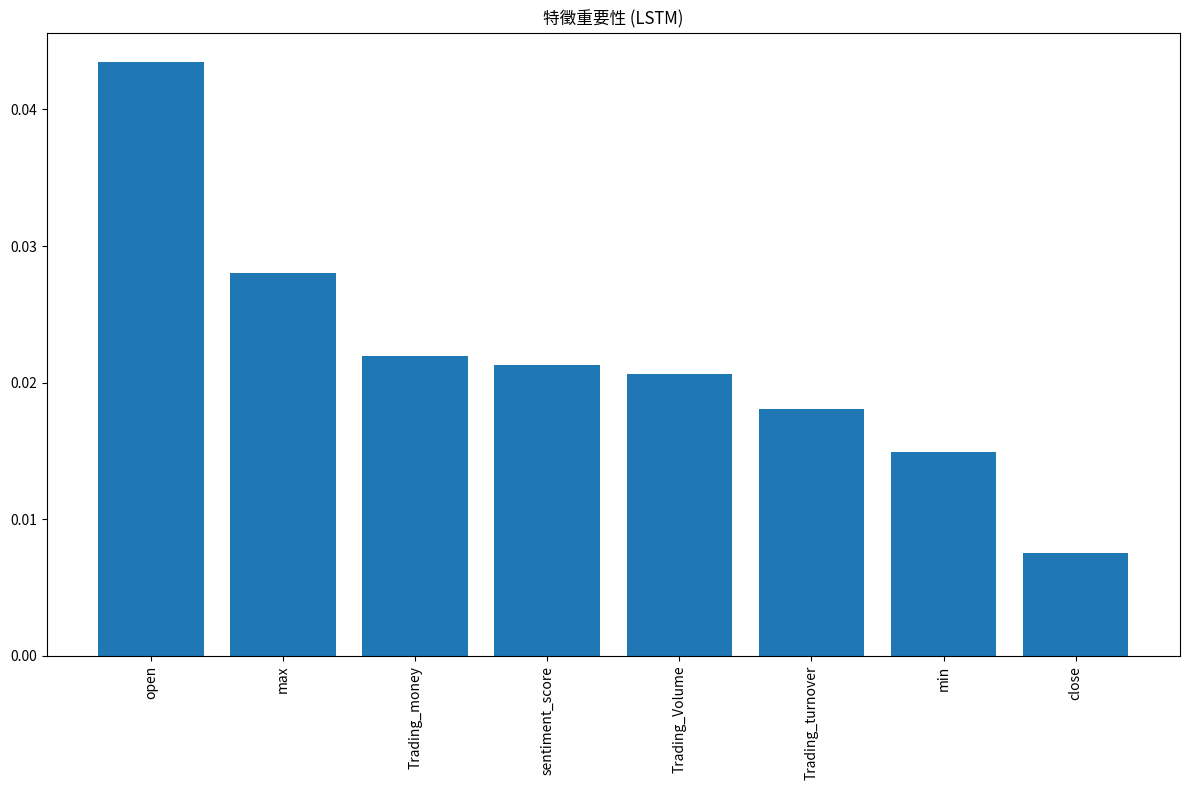

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/final-fivedays/3661_title_sentiment_FinGPT_5.csv", model_type='lstm', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 LSTM 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5249 - loss: 0.6927 - val_accuracy: 0.4872 - val_loss: 0.6937
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6908 - val_accuracy: 0.4872 - val_loss: 0.6942
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6893 - val_accuracy: 0.4872 - val_loss: 0.6947
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6882 - val_accuracy: 0.4872 - val_loss: 0.6950
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6873 - val_accuracy: 0.4872 - val_loss: 0.6951
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5422 - loss: 0.6863 - val_accuracy: 0.4872 - val_loss: 0.6951
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5434 - loss: 0.6845 - val_accuracy: 0.4872 - val_loss: 0.6952
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5453 - loss: 0.6839 - val_accuracy: 0.4769 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

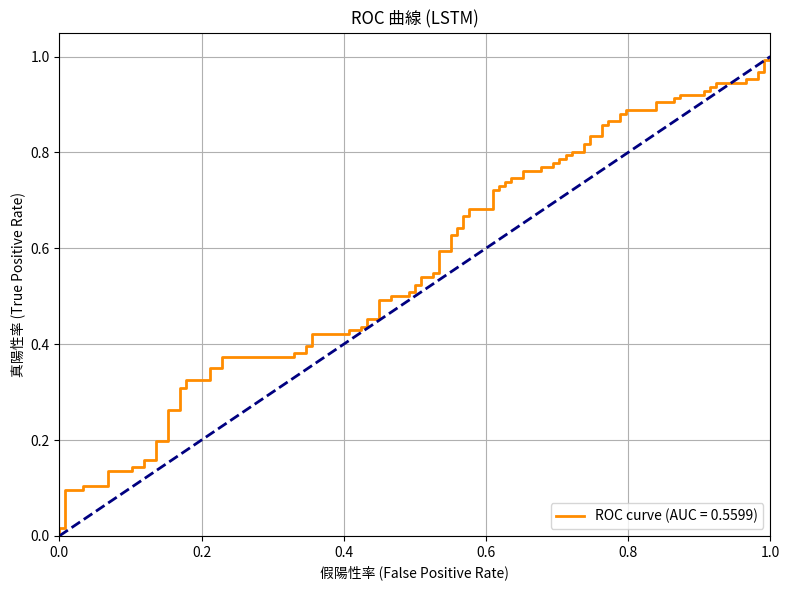

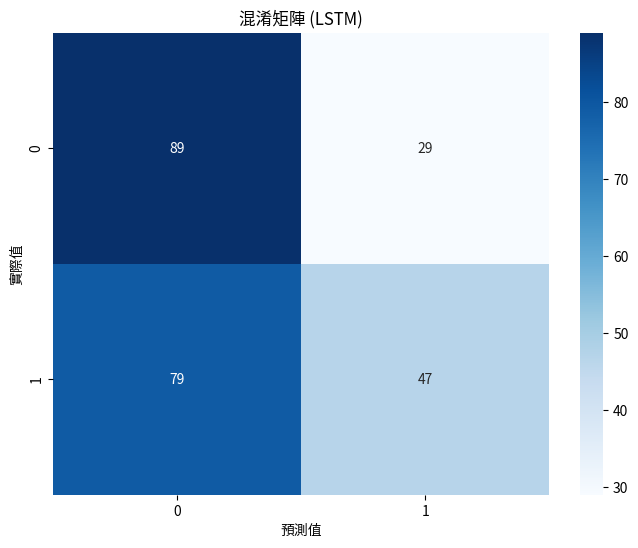

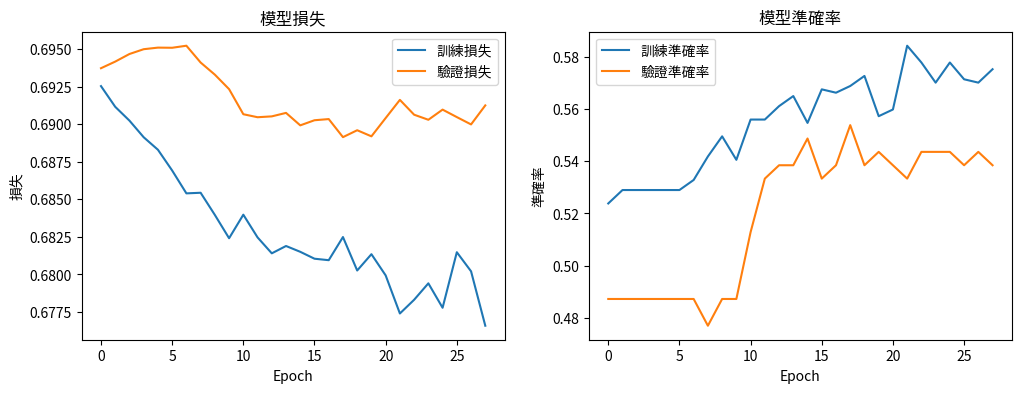

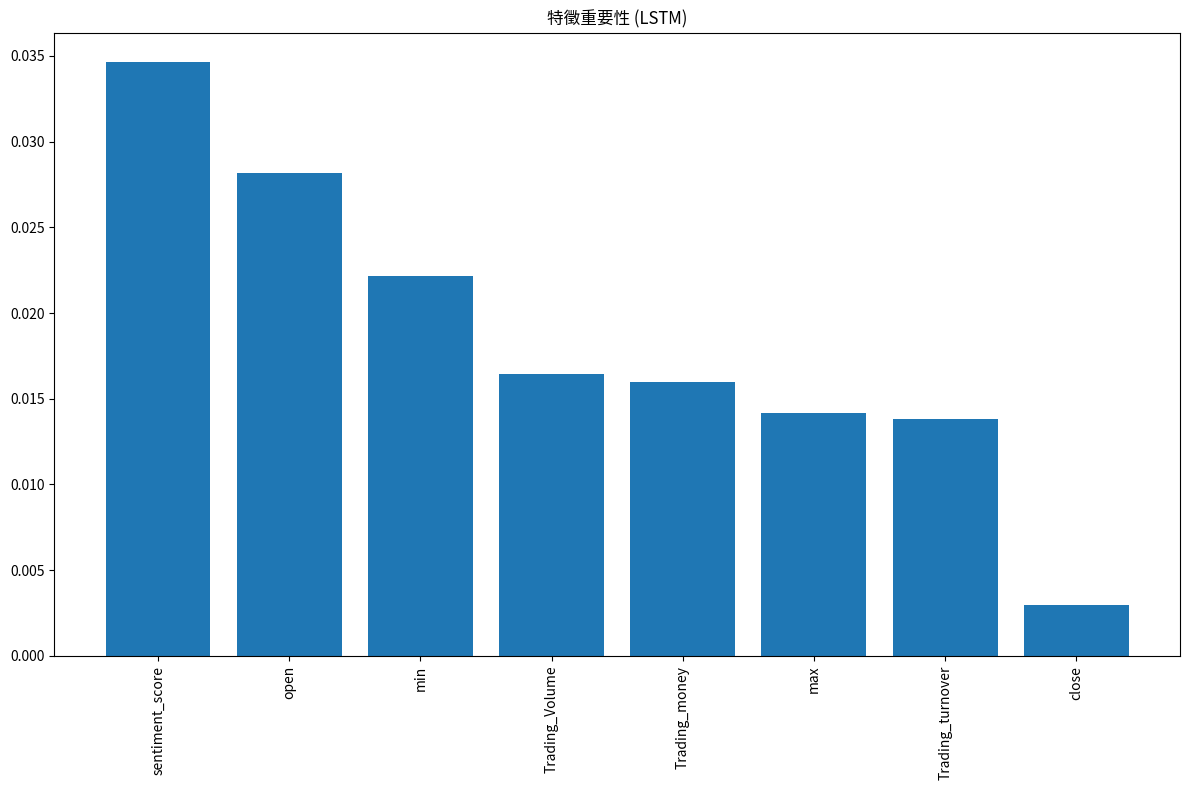

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/final-fivedays/3661_summary_sentiment_FinGPT_5.csv", model_type='lstm', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 LSTM 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 64)          │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,137 (121.63 KB)

 Trainable params: 31,137 (121.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.5422 - loss: 0.6920 - val_accuracy: 0.4872 - val_loss: 0.6942
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6906 - val_accuracy: 0.4872 - val_loss: 0.6947
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6892 - val_accuracy: 0.4872 - val_loss: 0.6952
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5422 - loss: 0.6890 - val_accuracy: 0.4872 - val_loss: 0.6955
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6873 - val_accuracy: 0.4872 - val_loss: 0.6959
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6870 - val_accuracy: 0.4872 - val_loss: 0.6960
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5422 - loss: 0.6860 - val_accuracy: 0.4872 - val_loss: 0.6951
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5443 - loss: 0.6854 - val_accuracy: 0.4872 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

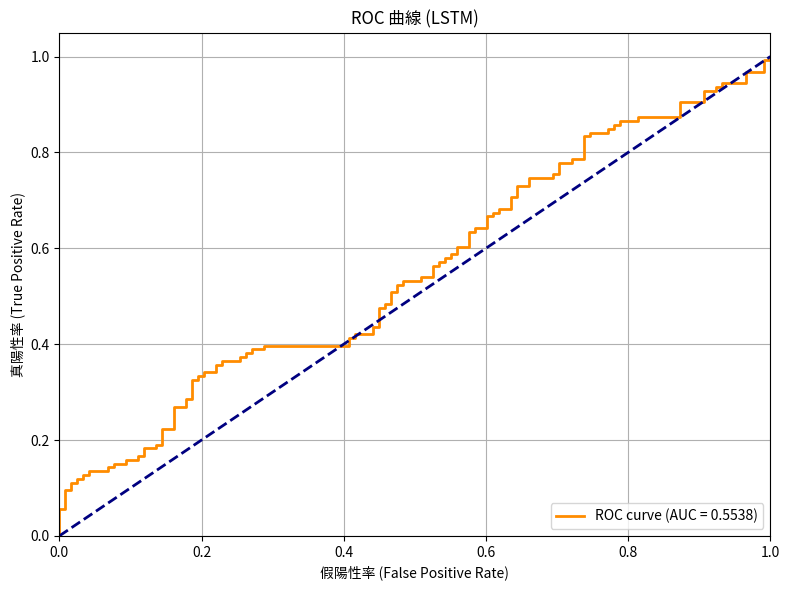

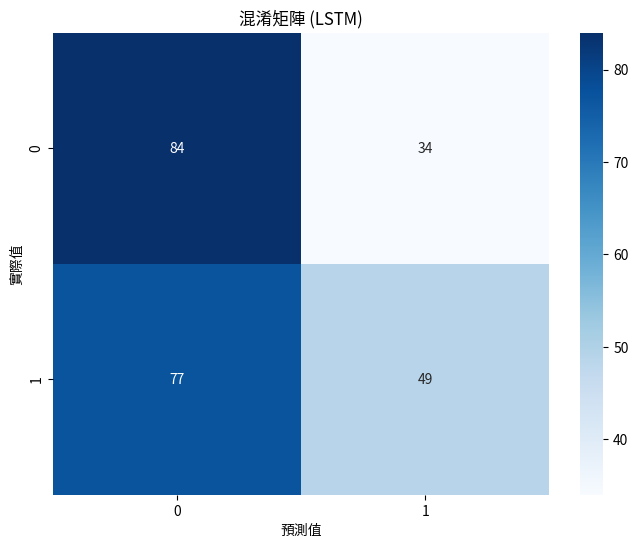

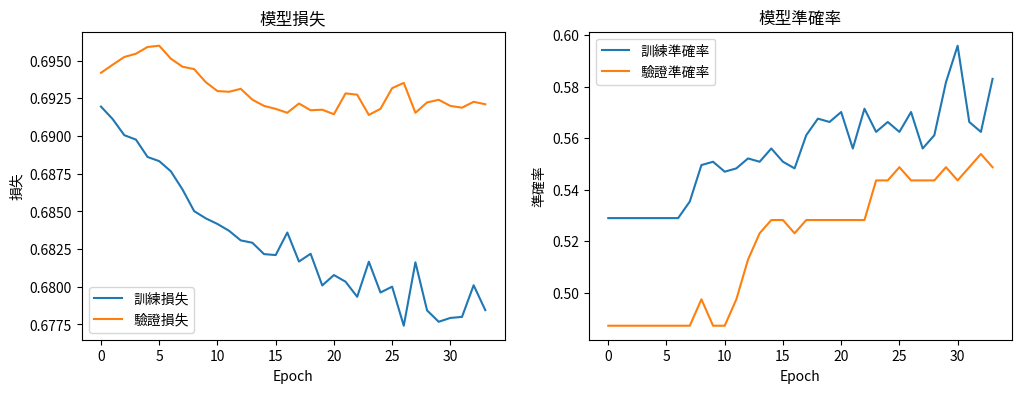

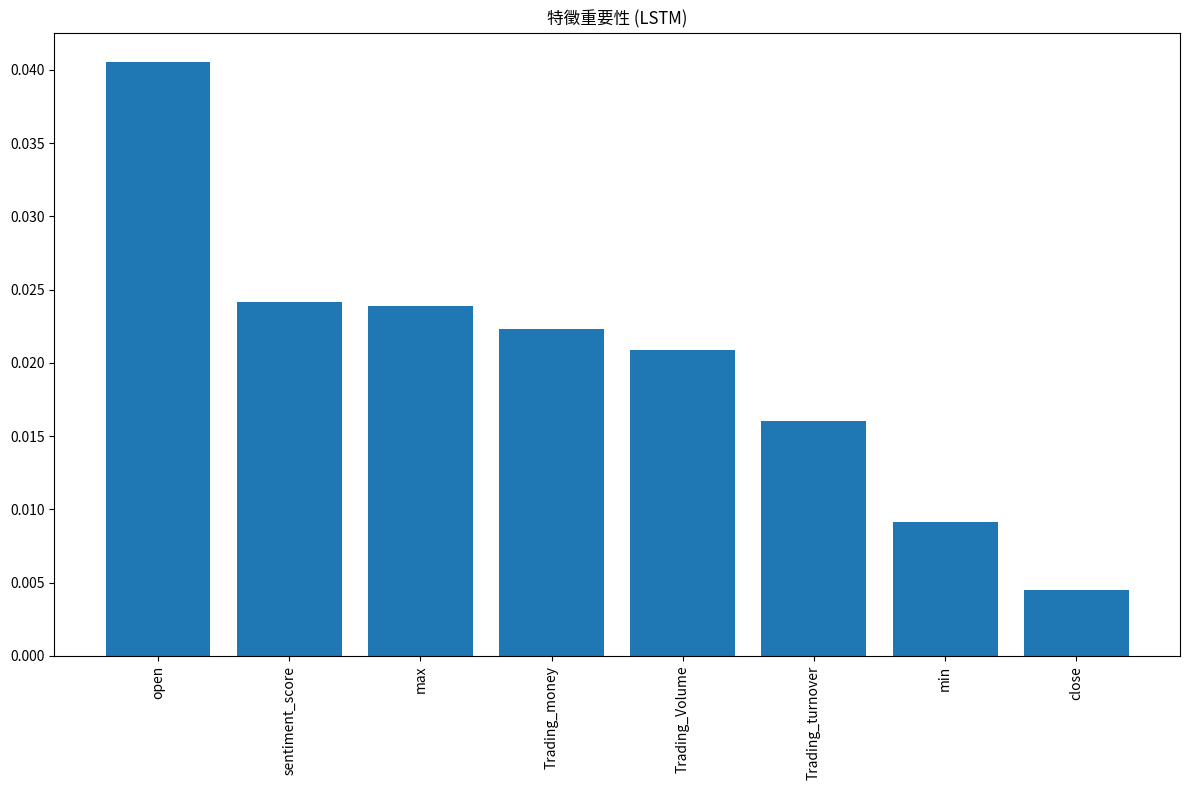

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/BERT/3661_stock_summary(1)_sentiment_5.csv", model_type='lstm', epochs=100, batch_size=32, select_columns=select_columns)

# 3037比較


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.4864 - loss: 0.6936 - val_accuracy: 0.4974 - val_loss: 0.6899
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5461 - loss: 0.6869 - val_accuracy: 0.5641 - val_loss: 0.6880
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5317 - loss: 0.6889 - val_accuracy: 0.5538 - val_loss: 0.6864
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5601 - loss: 0.6881 - val_accuracy: 0.5795 - val_loss: 0.6837
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5716 - loss: 0.6854 - val_accuracy: 0.5897 - val_loss: 0.6820
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5538 - loss: 0.6868 - val_accuracy: 0.5897 - val_loss: 0.6800
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5433 - loss: 0.6849 - val_accuracy: 0.5744 - val_loss: 0.6773
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5632 - loss: 0.6851 - val_accuracy: 0.5795

(<Sequential name=sequential, built=True>, MinMaxScaler())

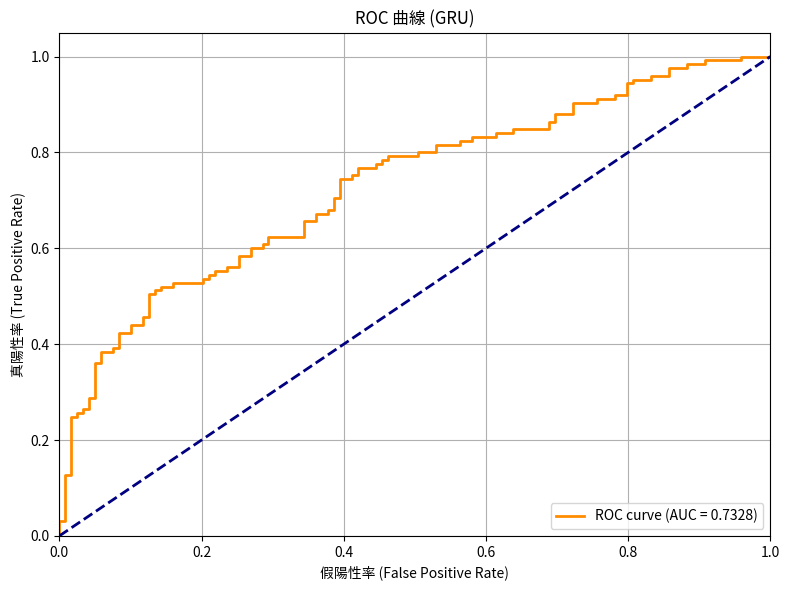

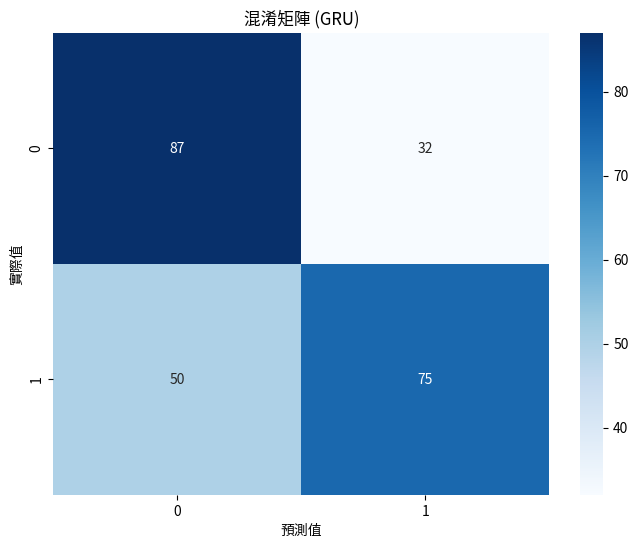

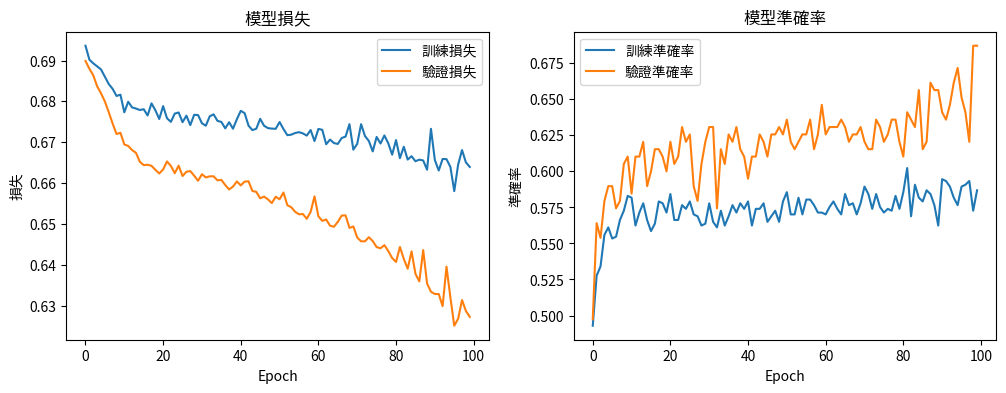

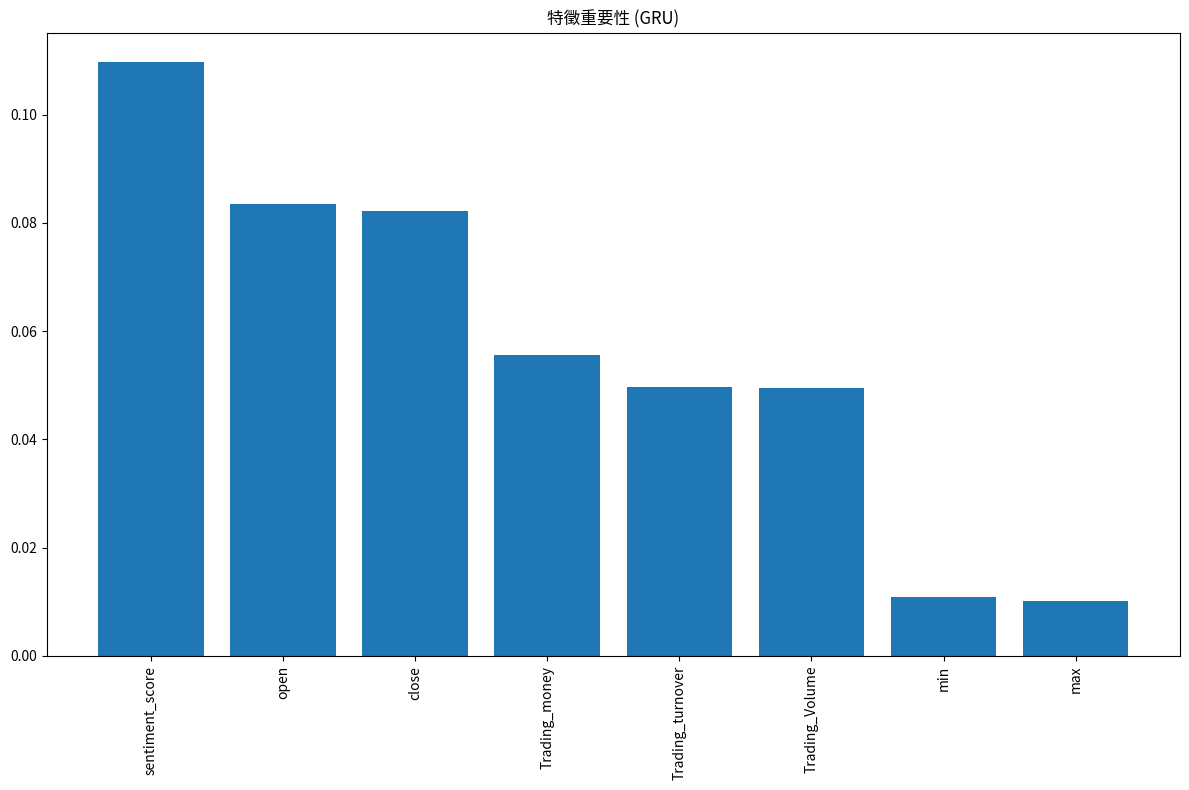

In [ ]:
# 執行程式時傳入要選擇的欄位名稱💫
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/BERT Final/3037_stock_title_sentiment.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.4913 - loss: 0.6936 - val_accuracy: 0.4974 - val_loss: 0.6942
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5096 - loss: 0.6938 - val_accuracy: 0.4923 - val_loss: 0.6916
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5304 - loss: 0.6901 - val_accuracy: 0.5436 - val_loss: 0.6901
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5518 - loss: 0.6878 - val_accuracy: 0.5795 - val_loss: 0.6886
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5551 - loss: 0.6850 - val_accuracy: 0.5641 - val_loss: 0.6869
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5418 - loss: 0.6860 - val_accuracy: 0.5846 - val_loss: 0.6841
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5654 - loss: 0.6814 - val_accuracy: 0.5846 - val_loss: 0.6823
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5813 - loss: 0.6766 - val_accuracy: 0.6000 -

(<Sequential name=sequential, built=True>, MinMaxScaler())

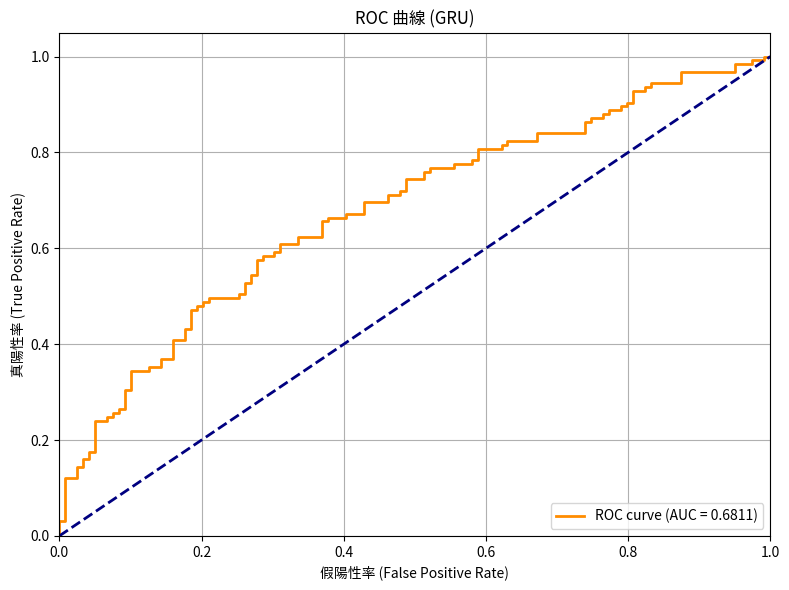

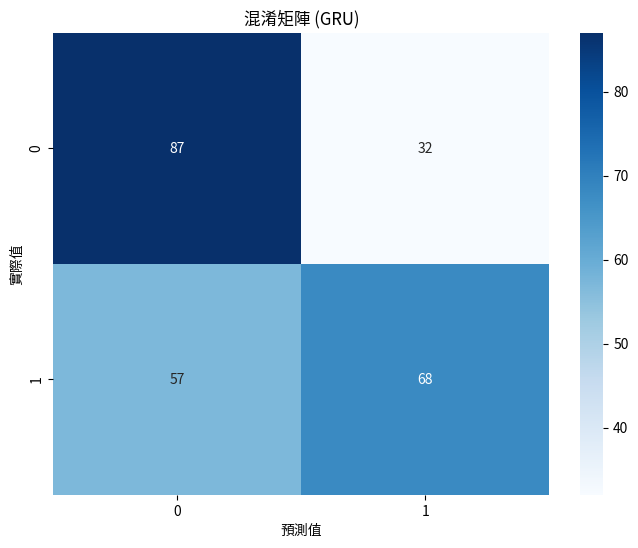

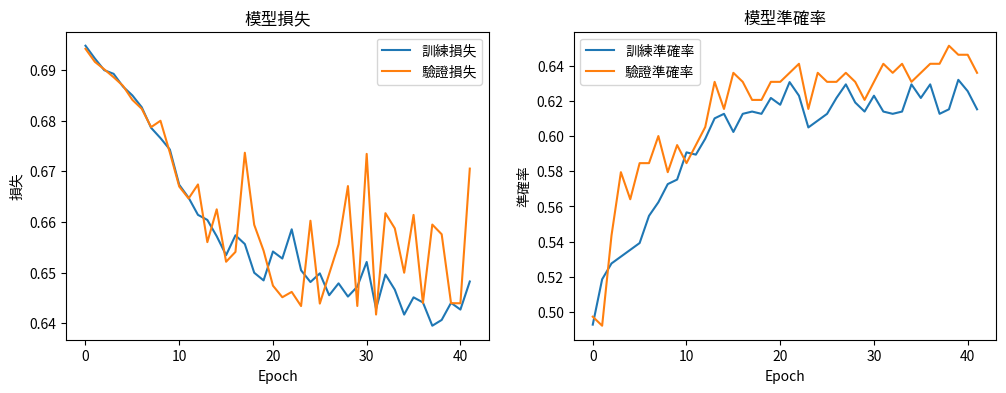

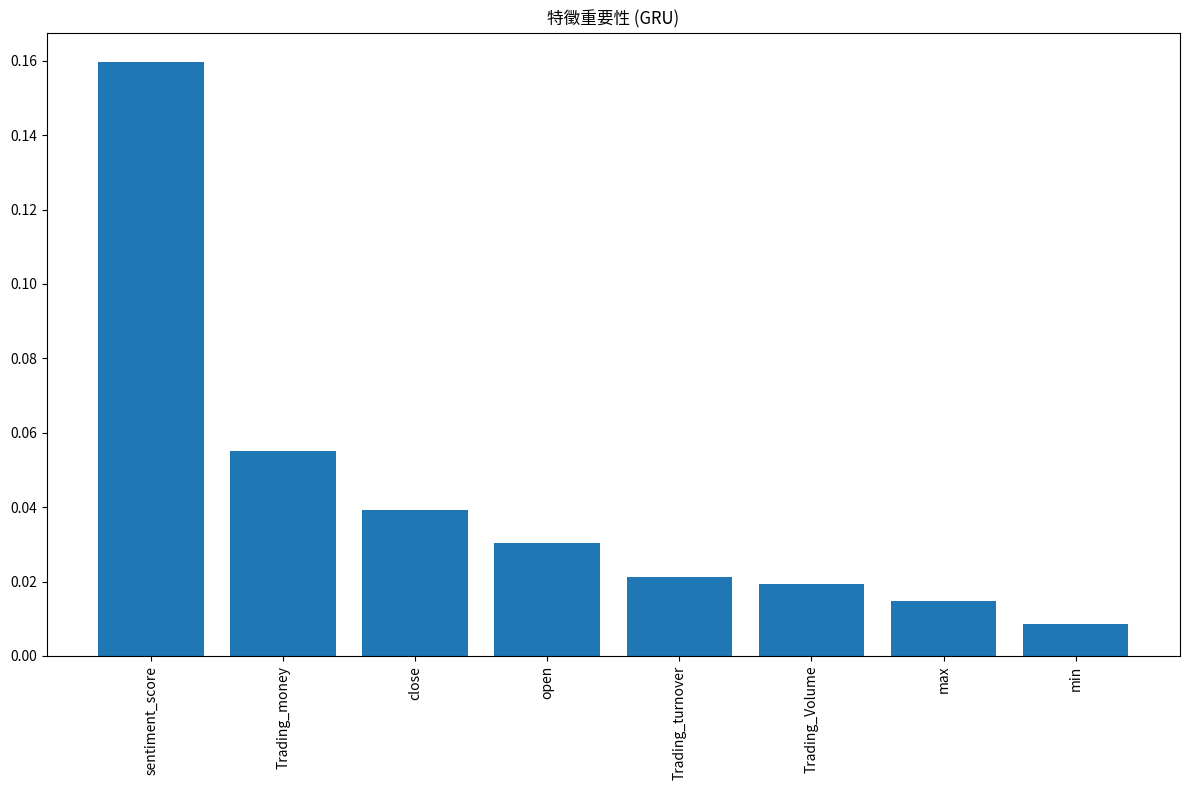

In [ ]:
# 執行程式時傳入要選擇的欄位名稱💫
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/BERT Final/3037_stock_summary(1)_sentiment.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.4835 - loss: 0.6927 - val_accuracy: 0.4974 - val_loss: 0.6898
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5199 - loss: 0.6894 - val_accuracy: 0.5692 - val_loss: 0.6860
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5349 - loss: 0.6886 - val_accuracy: 0.6051 - val_loss: 0.6824
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5438 - loss: 0.6852 - val_accuracy: 0.6205 - val_loss: 0.6780
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5586 - loss: 0.6839 - val_accuracy: 0.6154 - val_loss: 0.6745
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5700 - loss: 0.6802 - val_accuracy: 0.6256 - val_loss: 0.6705
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5580 - loss: 0.6805 - val_accuracy: 0.6205 - val_loss: 0.6674
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5721 - loss: 0.6756 - val_accuracy: 0.6256 - 

(<Sequential name=sequential, built=True>, MinMaxScaler())

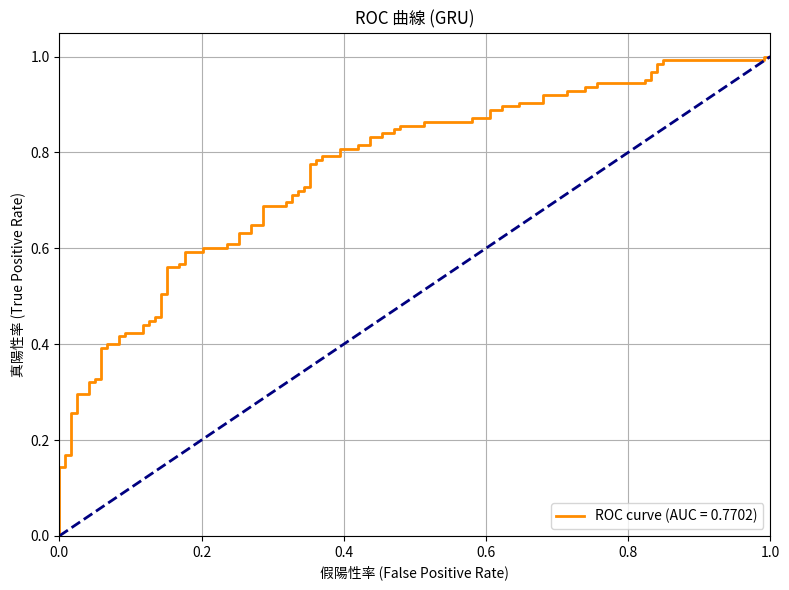

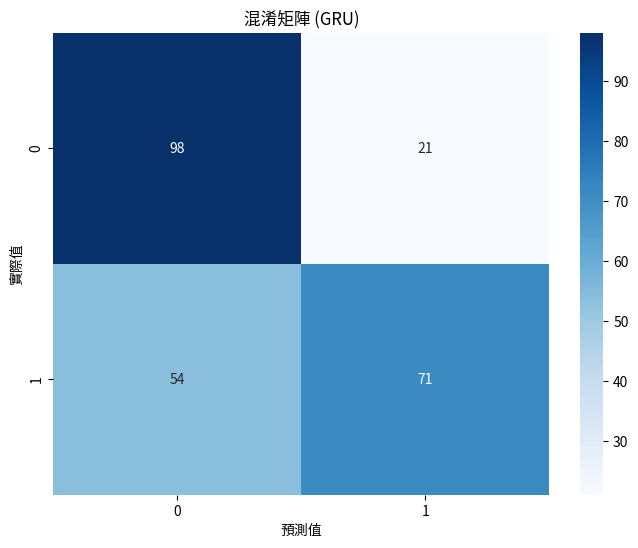

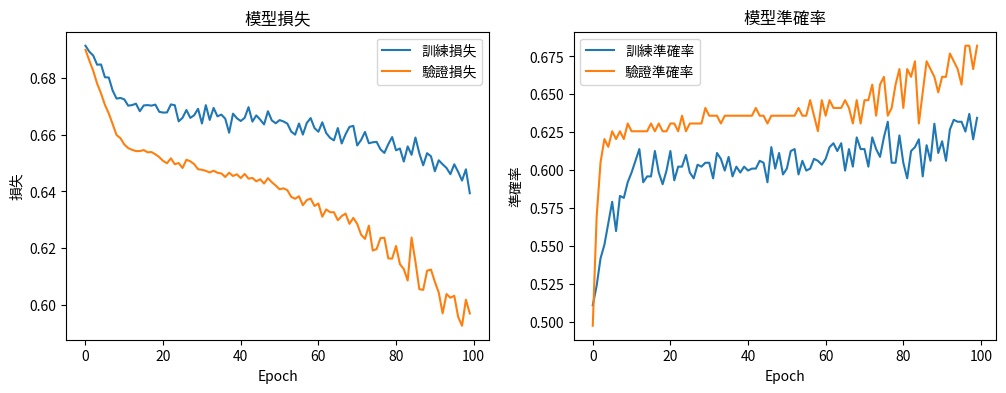

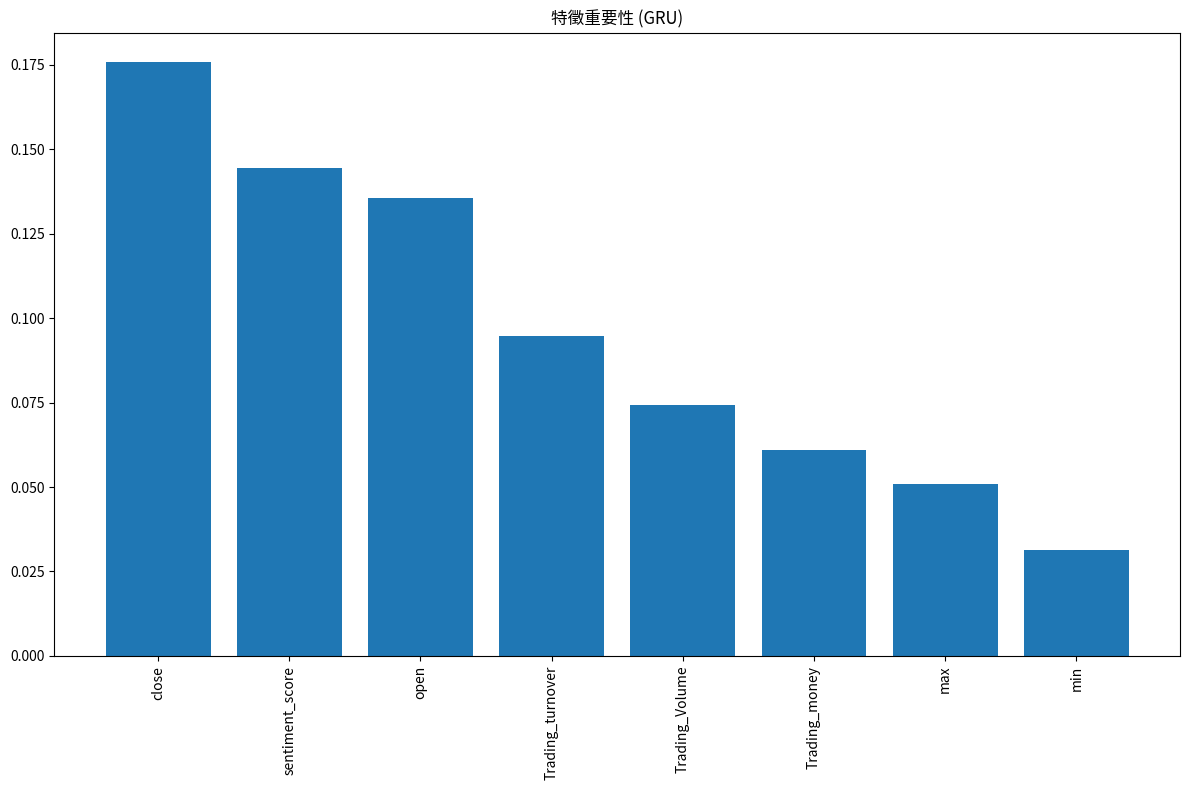

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/3037_title_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4828 - loss: 0.6933 - val_accuracy: 0.5692 - val_loss: 0.6862
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5329 - loss: 0.6870 - val_accuracy: 0.6103 - val_loss: 0.6787
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6127 - loss: 0.6828 - val_accuracy: 0.6308 - val_loss: 0.6705
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5905 - loss: 0.6751 - val_accuracy: 0.6564 - val_loss: 0.6634
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6049 - loss: 0.6722 - val_accuracy: 0.6718 - val_loss: 0.6561
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6189 - loss: 0.6604 - val_accuracy: 0.6718 - val_loss: 0.6508
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5982 - loss: 0.6698 - val_accuracy: 0.6615 - val_loss: 0.6483
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5728 - loss: 0.6692 - val_accuracy: 0.6513 

(<Sequential name=sequential, built=True>, MinMaxScaler())

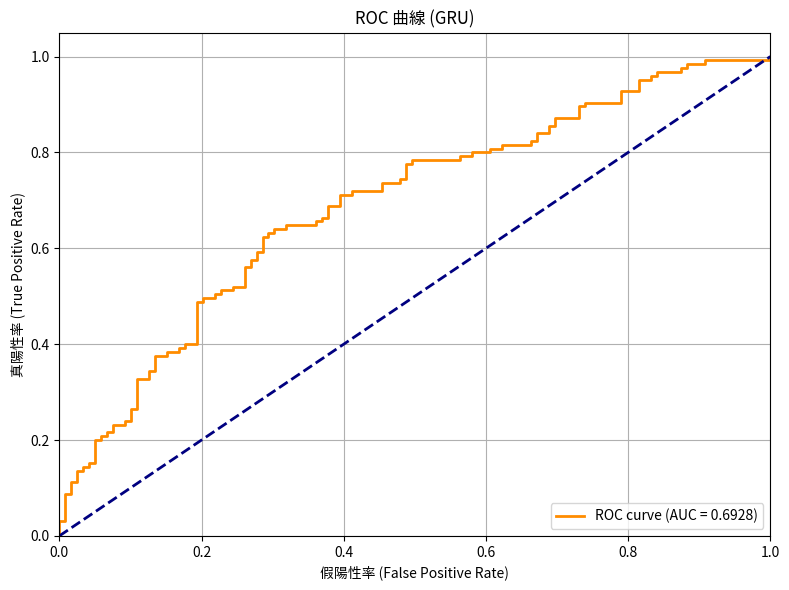

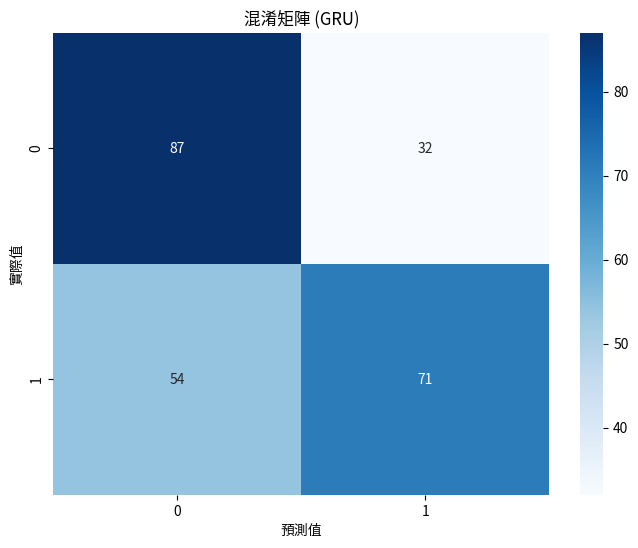

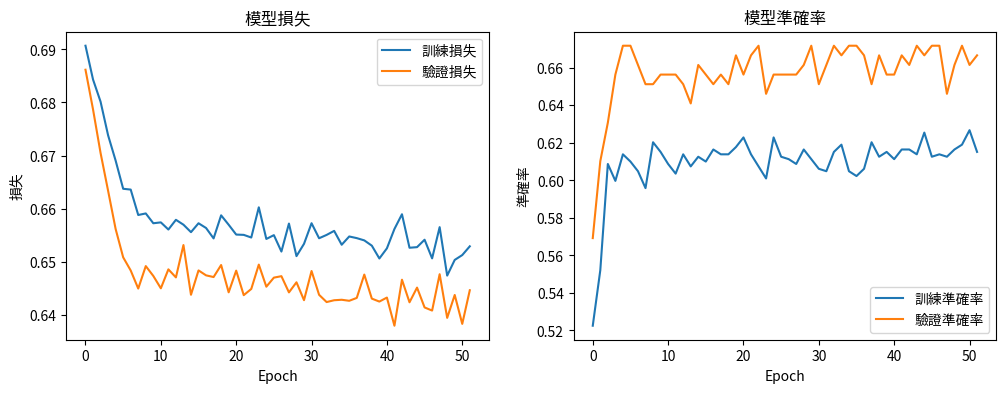

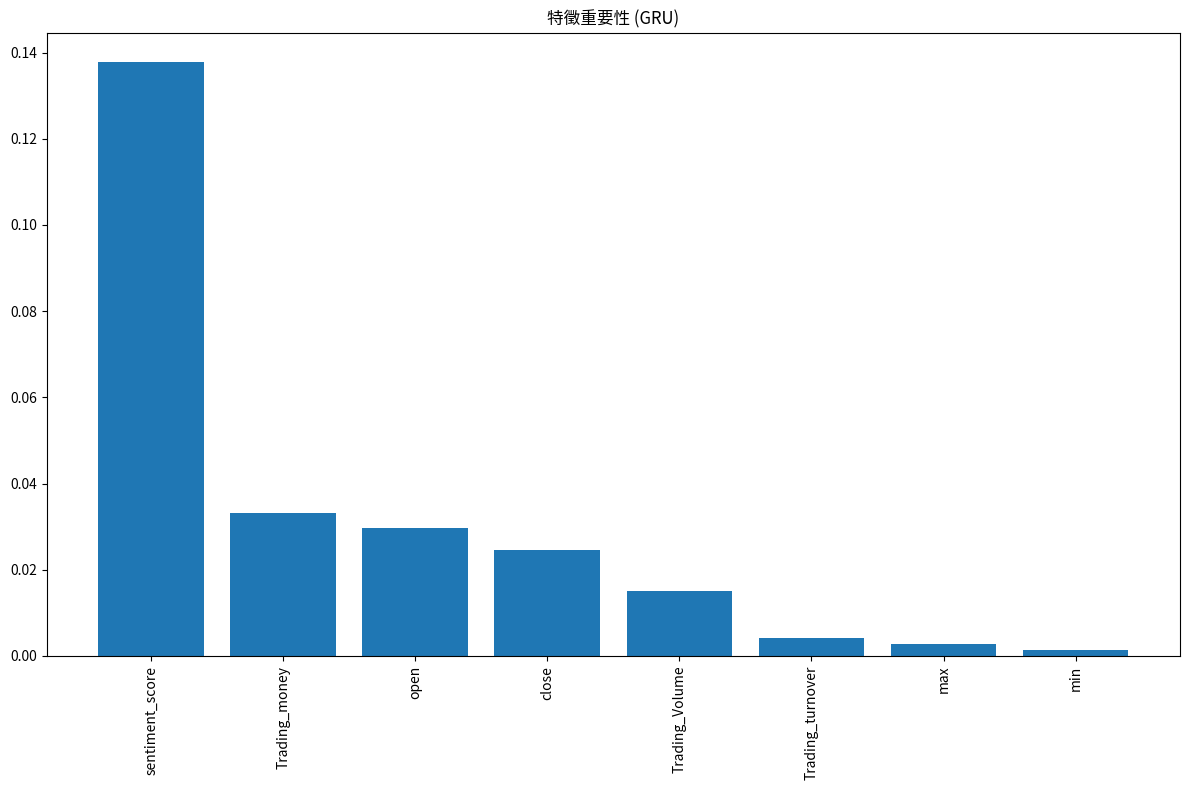

In [ ]:
# 執行程式時傳入要選擇的欄位名稱💫
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/FinGPT Final/3037_summary_sentiment_FinGPT.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)


=== 使用 GRU 模型進行股票漲跌預測 ===

僅保留欄位: ['date', 'stock_id', 'Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close', 'Trading_turnover', 'sentiment_score', 'target']
原始數據行數: 1216
刪除缺失值後的行數: 1216
刪除了 0 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'sentiment_score'],
      dtype='object')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,649 (92.38 KB)

 Trainable params: 23,649 (92.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.5218 - loss: 0.6902 - val_accuracy: 0.5949 - val_loss: 0.6836
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5432 - loss: 0.6833 - val_accuracy: 0.6359 - val_loss: 0.6750
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5962 - loss: 0.6762 - val_accuracy: 0.6564 - val_loss: 0.6658
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6164 - loss: 0.6683 - val_accuracy: 0.6564 - val_loss: 0.6569
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6224 - loss: 0.6631 - val_accuracy: 0.6564 - val_loss: 0.6520
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6081 - loss: 0.6601 - val_accuracy: 0.6462 - val_loss: 0.6483
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6171 - loss: 0.6564 - val_accuracy: 0.6462 - val_loss: 0.6452
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6230 - loss: 0.6566 - val_accuracy: 0.6410 -

(<Sequential name=sequential, built=True>, MinMaxScaler())

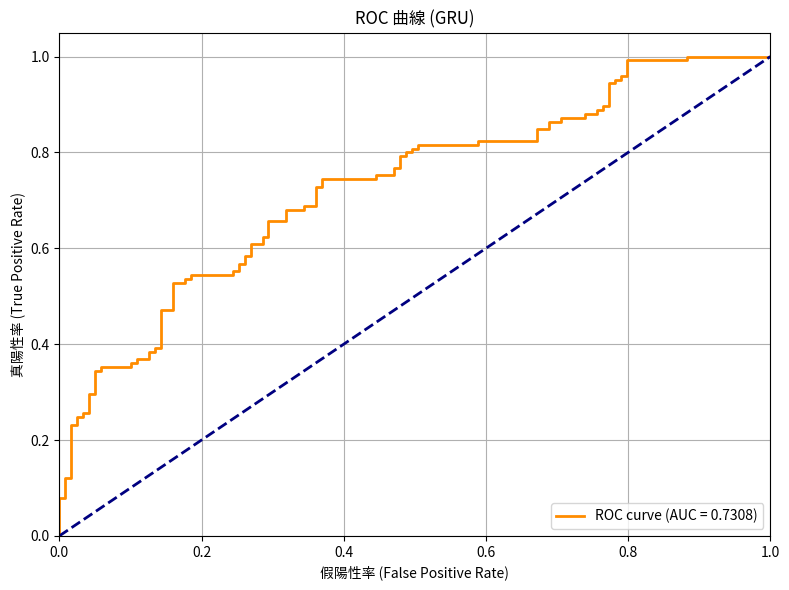

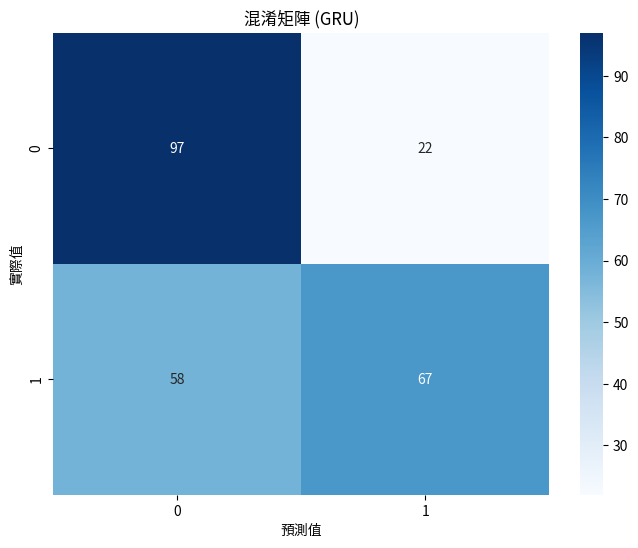

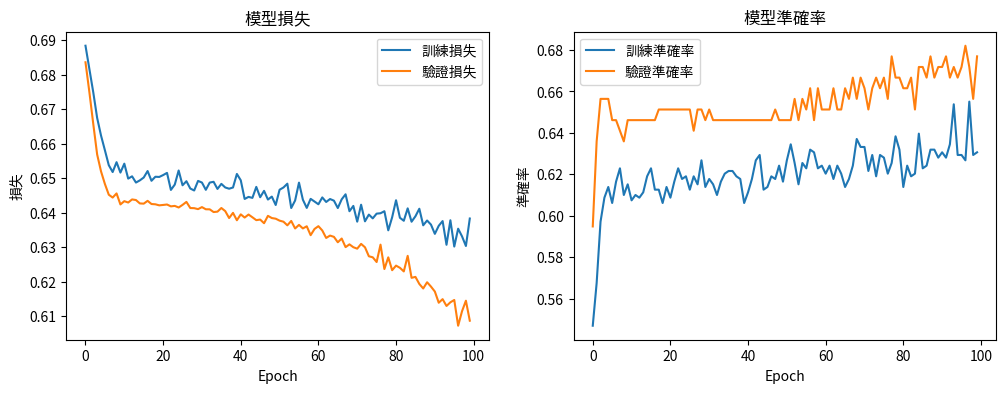

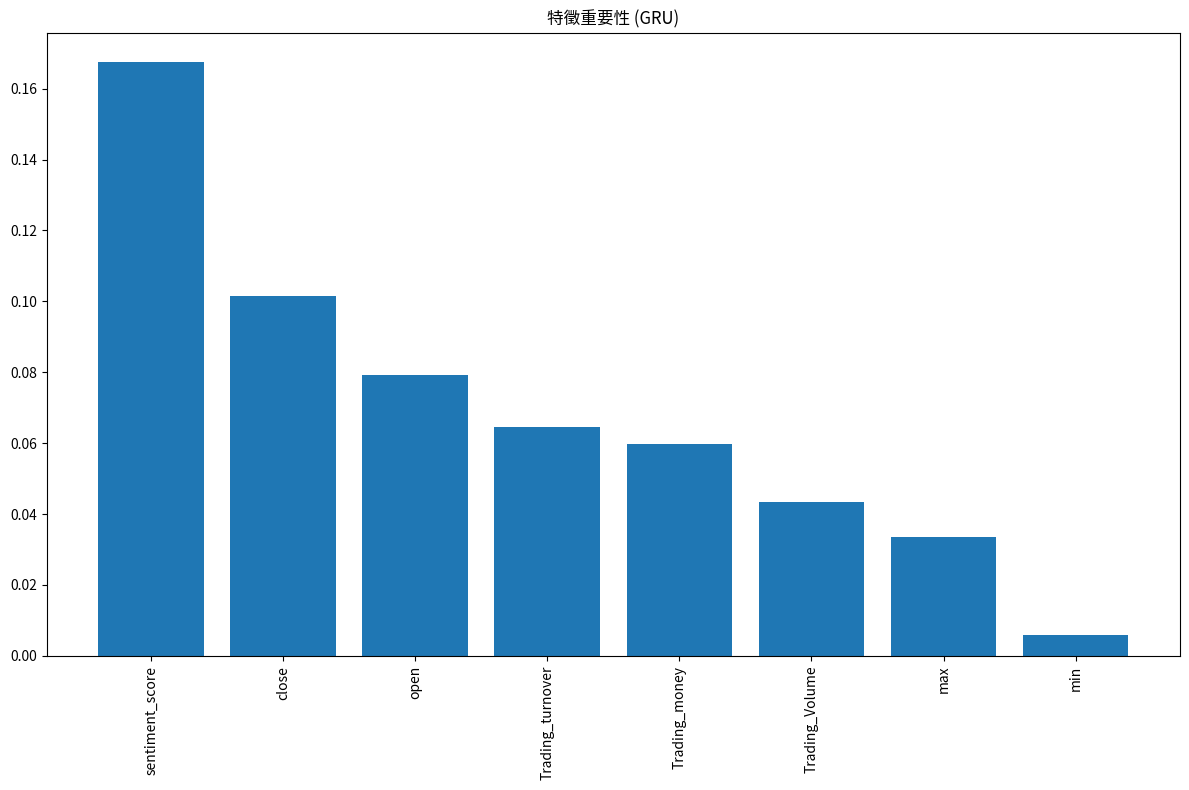

In [ ]:
# 執行程式時傳入要選擇的欄位名稱
select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
main("/content/drive/MyDrive/Regularization/final-fivedays/3037_summary_sentiment_FinGPT_5.csv", model_type='gru', epochs=100, batch_size=32, select_columns=select_columns)

# 網格搜尋(grid_search)

In [ ]:
from sklearn.model_selection import ParameterGrid

def grid_search(file_path, param_grid, drop_columns=None, select_columns=None):
    best_accuracy = 0
    best_params = None
    best_model = None
    best_scaler = None

    # 載入數據
    df = load_and_preprocess_data(file_path, drop_columns=drop_columns, select_columns=select_columns)
    X, y, scaler = feature_engineering(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    print("\n=== 開始 Grid Search ===")

    for params in ParameterGrid(param_grid):
        print(f"\n測試參數組合: {params}")

        try:
            model, _ = train_and_evaluate_model(
                X_train, y_train,
                X_test, y_test,
                model_type=params['model_type'],
                epochs=params['epochs'],
                batch_size=params['batch_size']
            )

            # 模型預測與評估
            X_test_reshaped = reshape_for_rnn(X_test)
            y_pred_prob = model.predict(X_test_reshaped, verbose=0)
            y_pred = (y_pred_prob > 0.5).astype(int)
            acc = accuracy_score(y_test, y_pred)

            print(f"參數組合準確率: {acc:.4f}")

            # 儲存最佳參數與模型
            if acc > best_accuracy:
                best_accuracy = acc
                best_params = params
                best_model = model
                best_scaler = scaler

        except Exception as e:
            print(f"錯誤於參數組合 {params}: {e}")

    print("\n=== Grid Search 完成 ===")
    print(f"最佳參數組合: {best_params}")
    print(f"最佳準確率: {best_accuracy:.4f}")

    return best_model, best_scaler, best_params


In [ ]:
if __name__ == "__main__":
    #select_columns = ['date','stock_id','Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','sentiment_score', 'target']
    drop_columns = ['spread']
    file_path = '/content/drive/MyDrive/Regularization/FinGPT Final/2303_title_sentiment_FinGPT.csv'
    param_grid = {
        'model_type': ['lstm'],
        'epochs': [50, 100],
        'batch_size': [32, 64],
        'dropout': [0.2, 0.3, 0.4]
    }
    best_model, best_scaler, best_params = grid_search(file_path, param_grid, select_columns=select_columns)

In [ ]:
#因3771於2019年有缺漏P/E ratio，所以缺失值填補時用公式進行填補(在預測時比其他股票要多drop掉EPS那行)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def load_and_preprocess_data(file_path, drop_columns=None, select_columns=None):
    df = pd.read_csv(file_path)
    if select_columns:
        print(f"僅保留欄位: {select_columns}")
        df = df[select_columns]
    elif drop_columns:
        print(f"移除欄位: {drop_columns}")
        df = df.drop(columns=drop_columns)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df_clean = df.dropna()
    print(f"原始數據行數: {len(df)}")
    print(f"刪除缺失值後的行數: {len(df_clean)}")
    print(f"刪除了 {len(df) - len(df_clean)} 行")
    print(f"處理後的缺失值數量: {df_clean.isnull().sum().sum()}")
    return df_clean

def feature_engineering(df):
    print("特徵欄位:", df.columns[2:-1])
    features = df[df.columns[2:-1]]
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    target = df['target'].values
    return scaled_features, target, scaler

def reshape_for_rnn(X):
    return X.reshape((X.shape[0], 1, X.shape[1]))

def train_and_evaluate_model(X_train, y_train, X_test, y_test,
                             model_type='gru', epochs=50, batch_size=32,
                             dropout=0.2, learning_rate=0.001):

    X_train_rnn = reshape_for_rnn(X_train)
    X_test_rnn = reshape_for_rnn(X_test)

    model = Sequential()
    model.add(Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(GRU(64, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(32))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        X_train_rnn, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        shuffle=False,
        callbacks=[early_stopping],
        verbose=1
    )

    model.summary()

    # 評估準確率
    _, accuracy = model.evaluate(X_test_rnn, y_test, verbose=0)

    # 預測
    y_pred_prob = model.predict(X_test_rnn)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # 繪製 ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假陽性率 (False Positive Rate)')
    plt.ylabel('真陽性率 (True Positive Rate)')
    plt.title(f'ROC 曲線 ({model_type.upper()})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('預測值')
    plt.ylabel('實際值')
    plt.title(f'混淆矩陣 ({model_type.upper()})')
    plt.tight_layout()
    plt.show()

    # 訓練過程圖
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='訓練損失')
    plt.plot(history.history['val_loss'], label='驗證損失')
    plt.title('模型損失')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='訓練準確率')
    plt.plot(history.history['val_accuracy'], label='驗證準確率')
    plt.title('模型準確率')
    plt.xlabel('Epoch')
    plt.ylabel('準確率')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n分類報告:")
    print(classification_report(y_test, y_pred))

    return model, accuracy

def grid_search(file_path, param_grid, drop_columns=None, select_columns=None):
    best_accuracy = 0
    best_params = None
    best_model = None
    best_scaler = None

    df = load_and_preprocess_data(file_path, drop_columns=drop_columns, select_columns=select_columns)
    X, y, scaler = feature_engineering(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    print("\n=== 開始 Grid Search ===")

    for params in ParameterGrid(param_grid):
        print(f"\n測試參數組合: {params}")
        try:
            model, acc = train_and_evaluate_model(
                X_train, y_train,
                X_test, y_test,
                model_type=params['model_type'],
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                dropout=params['dropout'],
                learning_rate=params['learning_rate']
            )

            print(f"參數組合準確率: {acc:.4f}")

            if acc > best_accuracy:
                best_accuracy = acc
                best_params = params
                best_model = model
                best_scaler = scaler

        except Exception as e:
            print(f"錯誤於參數組合 {params}: {e}")

    print("\n=== Grid Search 完成 ===")
    print(f"最佳參數組合: {best_params}")
    print(f"最佳準確率: {best_accuracy:.4f}")

    return best_model, best_scaler, best_params

if __name__ == "__main__":
    file_path = '/content/drive/MyDrive/Regularization/FinGPT Final/3711_summary_sentiment_FinGPT.csv'
    drop_columns = ['spread','EPS']
    param_grid = {
        'model_type': ['gru'],
        'epochs': [100],
        'batch_size': [32],
        'dropout': [0.2],
        'learning_rate': [0.001]
    }

    best_model, best_scaler, best_params = grid_search(file_path, param_grid, drop_columns=drop_columns) #根據刪除會保留進行修改

移除欄位: ['spread']
原始數據行數: 1216
刪除缺失值後的行數: 1210
刪除了 6 行
處理後的缺失值數量: 0
特徵欄位: Index(['Trading_Volume', 'Trading_money', 'open', 'max', 'min', 'close',
       'Trading_turnover', 'RSI', 'MA', 'FastK', 'FastD', 'Dividend Yield',
       'P/E', 'P/B', 'sentiment_score'],
      dtype='object')

=== 開始 Grid Search ===

測試參數組合: {'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'model_type': 'gru'}
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.5191 - loss: 0.6830 - val_accuracy: 0.4794 - val_loss: 0.6674
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5833 - loss: 0.6546 - val_accuracy: 0.7216 - val_loss: 0.6275
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6725 - loss: 0.6218 - val_accuracy: 0.7371 - val_loss: 0.5726
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6999 - loss: 0.5824 - val_accuracy: 0.7526 - val_loss: 0.5221
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7025 - loss: 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 1, 64)          │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,981 (292.90 KB)

 Trainable params: 24,993 (97.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,988 (195.27 KB)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


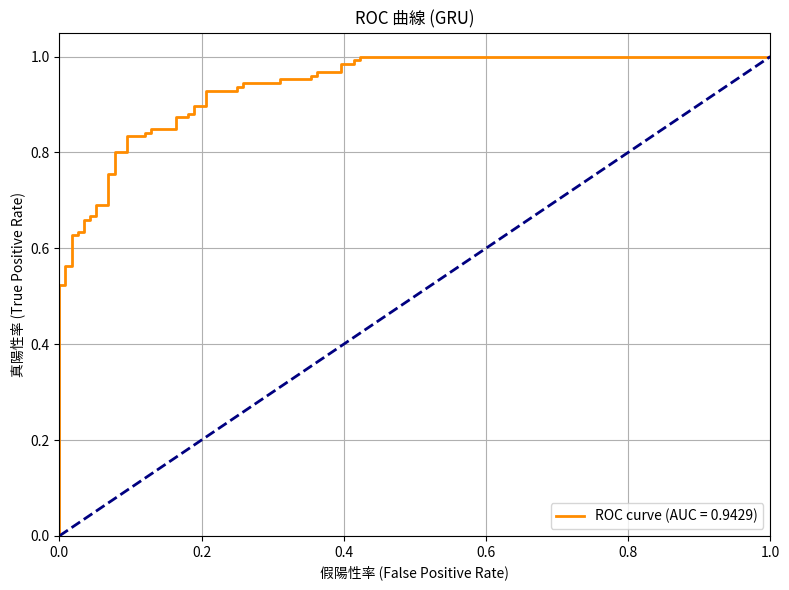

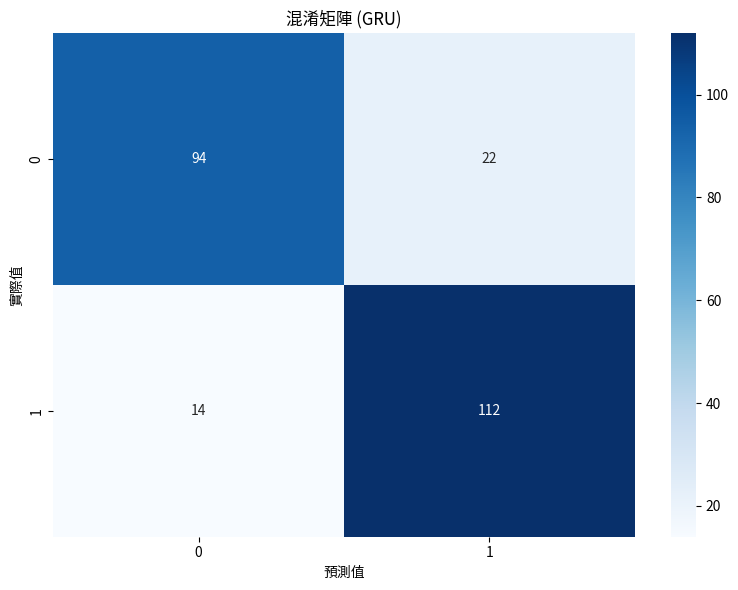

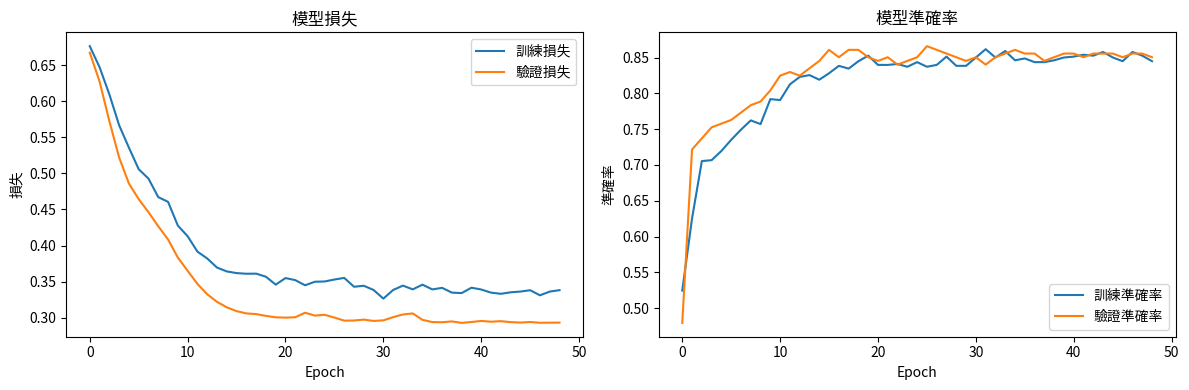


分類報告:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       116
           1       0.84      0.89      0.86       126

    accuracy                           0.85       242
   macro avg       0.85      0.85      0.85       242
weighted avg       0.85      0.85      0.85       242

參數組合準確率: 0.8512

=== Grid Search 完成 ===
最佳參數組合: {'batch_size': 32, 'dropout': 0.2, 'epochs': 100, 'learning_rate': 0.001, 'model_type': 'gru'}
最佳準確率: 0.8512


In [ ]:
#網格搜索
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

def load_and_preprocess_data(file_path, drop_columns=None, select_columns=None):
    df = pd.read_csv(file_path)
    if select_columns:
        print(f"僅保留欄位: {select_columns}")
        df = df[select_columns]
    elif drop_columns:
        print(f"移除欄位: {drop_columns}")
        df = df.drop(columns=drop_columns)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')
    df_clean = df.dropna()
    print(f"原始數據行數: {len(df)}")
    print(f"刪除缺失值後的行數: {len(df_clean)}")
    print(f"刪除了 {len(df) - len(df_clean)} 行")
    print(f"處理後的缺失值數量: {df_clean.isnull().sum().sum()}")
    return df_clean

def feature_engineering(df):
    print("特徵欄位:", df.columns[2:-1])
    features = df[df.columns[2:-1]]
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)
    target = df['target'].values
    return scaled_features, target, scaler

def reshape_for_rnn(X):
    return X.reshape((X.shape[0], 1, X.shape[1]))

def train_and_evaluate_model(X_train, y_train, X_test, y_test,
                             model_type='gru', epochs=50, batch_size=32,
                             dropout=0.2, learning_rate=0.001):

    X_train_rnn = reshape_for_rnn(X_train)
    X_test_rnn = reshape_for_rnn(X_test)

    model = Sequential()
    model.add(Input(shape=(X_train_rnn.shape[1], X_train_rnn.shape[2])))
    model.add(GRU(64, return_sequences=True))
    model.add(Dropout(dropout))
    model.add(GRU(32))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_train_rnn, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        shuffle=False,
        callbacks=[early_stopping],
        verbose=1
    )

    model.summary()

    # 評估準確率
    _, accuracy = model.evaluate(X_test_rnn, y_test, verbose=0)

    # 預測
    y_pred_prob = model.predict(X_test_rnn)
    y_pred = (y_pred_prob > 0.5).astype("int32")

    # 繪製 ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假陽性率 (False Positive Rate)')
    plt.ylabel('真陽性率 (True Positive Rate)')
    plt.title(f'ROC 曲線 ({model_type.upper()})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('預測值')
    plt.ylabel('實際值')
    plt.title(f'混淆矩陣 ({model_type.upper()})')
    plt.tight_layout()
    plt.show()

    # 訓練過程圖
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='訓練損失')
    plt.plot(history.history['val_loss'], label='驗證損失')
    plt.title('模型損失')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='訓練準確率')
    plt.plot(history.history['val_accuracy'], label='驗證準確率')
    plt.title('模型準確率')
    plt.xlabel('Epoch')
    plt.ylabel('準確率')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\n分類報告:")
    print(classification_report(y_test, y_pred))

    return model, accuracy

def grid_search(file_path, param_grid, drop_columns=None, select_columns=None):
    best_accuracy = 0
    best_params = None
    best_model = None
    best_scaler = None

    df = load_and_preprocess_data(file_path, drop_columns=drop_columns, select_columns=select_columns)
    X, y, scaler = feature_engineering(df)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    print("\n=== 開始 Grid Search ===")

    for params in ParameterGrid(param_grid):
        print(f"\n測試參數組合: {params}")
        try:
            model, acc = train_and_evaluate_model(
                X_train, y_train,
                X_test, y_test,
                model_type=params['model_type'],
                epochs=params['epochs'],
                batch_size=params['batch_size'],
                dropout=params['dropout'],
                learning_rate=params['learning_rate']
            )

            print(f"參數組合準確率: {acc:.4f}")

            if acc > best_accuracy:
                best_accuracy = acc
                best_params = params
                best_model = model
                best_scaler = scaler

        except Exception as e:
            print(f"錯誤於參數組合 {params}: {e}")

    print("\n=== Grid Search 完成 ===")
    print(f"最佳參數組合: {best_params}")
    print(f"最佳準確率: {best_accuracy:.4f}")

    return best_model, best_scaler, best_params

if __name__ == "__main__":
    file_path = '/content/drive/MyDrive/Regularization/final-fivedays/3661_summary_sentiment_FinGPT_5.csv'
    #select_columns = ['date','stock_id','Trading_Volume','Trading_money', 'open', 'max', 'min', 'close','Trading_turnover','target']
    drop_columns = ['spread']
    param_grid = {
        'model_type': ['gru'],
        'epochs': [100],
        'batch_size': [32],
        'dropout': [0.2],
        'learning_rate': [0.001]
    }

    best_model, best_scaler, best_params = grid_search(file_path, param_grid, drop_columns=drop_columns) #根據刪除會保留進行修改


# 資料的查詢

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1：讀取 CSV
file_path = '/content/drive/MyDrive/Regularization/FinGPT Final/3711_summary_sentiment_FinGPT.csv'
df = pd.read_csv(file_path)

# Step 2：顯示資料基本資訊
print("✅ 資料筆數：", len(df))
print("✅ 欄位名稱：", df.columns.tolist())

# Step 3：檢查 'target' 類別分布（假設 1 表示上漲，0 表示下跌）
if 'target' in df.columns:
    class_counts = df['target'].value_counts().sort_index()
    class_ratio = class_counts / len(df)

    print("\n📊 類別數量分布：")
    print(class_counts)

    print("\n📈 類別比例分布：")
    print(class_ratio)

    # Step 4：畫出長條圖
    class_counts.plot(kind='bar', color=['lightgreen', 'salmon'])
    plt.title('3661 上漲(1)與下跌(0) 類別分布')
    plt.xlabel('類別 (target)')
    plt.ylabel('樣本數')
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("⚠️ 找不到 'target' 欄位，請確認欄位名稱是否正確。")

In [ ]:
#查詢資料切割時間(訓練、驗證、測試)
#雙層LSTM和GRU
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import os
import argparse
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, auc

# 如果TensorFlow顯示太多訊息，可以設置為只顯示錯誤
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 1. 加載和預處理數據
# 修改 load_and_preprocess_data，接受 drop_columns 參數
def load_and_preprocess_data(file_path, drop_columns=None, select_columns=None):
    df = pd.read_csv(file_path)

    # 如果有選擇特定欄位
    if select_columns:
        print(f"僅保留欄位: {select_columns}")
        df = df[select_columns]

    # 如果有傳入需要刪除的欄位
    elif drop_columns:
        print(f"移除欄位: {drop_columns}")
        df = df.drop(columns=drop_columns)

    # 將日期轉換為datetime格式並按日期排序
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date')

    # 刪除含有缺失值的行
    df_clean = df.dropna()

    # 顯示原始數據和處理後的數據狀況
    print(f"原始數據行數: {len(df)}")
    print(f"刪除缺失值後的行數: {len(df_clean)}")
    print(f"刪除了 {len(df) - len(df_clean)} 行")

    missing_count = df_clean.isnull().sum().sum()
    print(f"處理後的缺失值數量: {missing_count}")

    return df_clean



# 2. 特徵工程
def feature_engineering(df):
    # 選擇數值型特徵
    print("特徵欄位:", df.columns[2:-1])

    features = df[df.columns[2:-1]]
    # 標準化特徵
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(features)

    # 目標變數
    target = df['target'].values

    return scaled_features, target, scaler


# 3. 創建模型(要改模型的組合、參數、都是在這改)
def create_model(input_shape, model_type='gru'):
    model = Sequential()

    if model_type.lower() == 'lstm':
        # 第一層LSTM，返回序列
        model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))

        # 第二層LSTM
        model.add(LSTM(units=32))
        model.add(Dropout(0.2))
    else:
        # 第一層GRU，返回序列
        model.add(GRU(units=64, return_sequences=True, input_shape=input_shape))
        model.add(Dropout(0.2))

        # 第二層GRU
        model.add(GRU(units=32))
        model.add(Dropout(0.2))

    # 輸出層 - 二元分類問題
    #model.add(Dense(64, activation='relu'))  # 對應前面 units=64
    #model.add(Dense(32, activation='relu'))  # 可進一步萃取特徵
    model.add(Dense(1, activation='sigmoid'))  # 輸出層

    # 指定學習率的 Adam 優化器
    #optimizer = Adam(learning_rate=0.005)
    # 編譯模型
    #model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy']) #若要指定learning_rate要修改這兩行


    # 編譯模型
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # 顯示模型摘要
    model.summary()

    return model

# 4. 重塑數據以適合模型輸入格式
def reshape_for_rnn(X):
    # 為RNN添加時間步維度 [樣本, 時間步, 特徵]
    # 由於我們的任務是同一行預測，時間步設為1
    return X.reshape(X.shape[0], 1, X.shape[1])

# 5. 訓練和評估模型
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type='gru', epochs=100, batch_size=32):
    # 重塑訓練和測試數據
    X_train_reshaped = reshape_for_rnn(X_train)
    X_test_reshaped = reshape_for_rnn(X_test)

    # 創建模型
    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
    model = create_model(input_shape, model_type)

    # 早停設置以防止過擬合
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=50,
        restore_best_weights=True
    )

    # 訓練模型
    history = model.fit(
        X_train_reshaped, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        shuffle=False,
        callbacks=[early_stopping],
        verbose=1
    )

    # 評估模型
    y_pred_prob = model.predict(X_test_reshaped, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)


    # 計算準確率
    accuracy = accuracy_score(y_test, y_pred)
    print(f'測試集準確率: {accuracy:.4f}')

    # 分類報告
    print("\n分類報告:")
    print(classification_report(y_test, y_pred))

    # 繪製 ROC 曲線
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('假陽性率 (False Positive Rate)')
    plt.ylabel('真陽性率 (True Positive Rate)')
    plt.title(f'ROC 曲線 ({model_type.upper()})')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()

    # 混淆矩陣
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('預測值')
    plt.ylabel('實際值')
    plt.title(f'混淆矩陣 ({model_type.upper()})')


    # 繪製訓練過程中的損失和準確率
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='訓練損失')
    plt.plot(history.history['val_loss'], label='驗證損失')
    plt.title('模型損失')
    plt.xlabel('Epoch')
    plt.ylabel('損失')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='訓練準確率')
    plt.plot(history.history['val_accuracy'], label='驗證準確率')
    plt.title('模型準確率')
    plt.xlabel('Epoch')
    plt.ylabel('準確率')
    plt.legend()


    return model, history

# 特徵重要性計算方法
def calculate_feature_importance(model, X_test, feature_names):
    """使用簡單的排列特徵重要性方法，不依賴於外部庫"""
    print("計算特徵重要性...")

    # 重塑測試數據
    X_test_reshaped = reshape_for_rnn(X_test)

    # 獲取基準準確率
    y_pred_base = model.predict(X_test_reshaped, verbose=0)

    # 特徵重要性存儲
    feature_importance = []

    # 對於每個特徵
    for i in range(X_test.shape[1]):
        print(f"評估特徵 {i+1}/{X_test.shape[1]}: {feature_names[i]}")

        # 創建數據副本
        X_permuted = X_test.copy()

        # 打亂特定特徵
        np.random.shuffle(X_permuted[:, i])

        # 重塑數據
        X_permuted_reshaped = reshape_for_rnn(X_permuted)

        # 使用打亂後的數據進行預測
        y_pred_permuted = model.predict(X_permuted_reshaped, verbose=0)

        # 計算預測差異
        importance = np.mean(np.abs(y_pred_base - y_pred_permuted))
        feature_importance.append(importance)

    return np.array(feature_importance)


# 主程序，整合LSTM和GRU模型
def main(file_path, model_type='gru', epochs=100, batch_size=32, drop_columns=None, select_columns=None):
    try:
        # 確保TensorFlow環境乾淨
        tf.keras.backend.clear_session()

        print(f"\n=== 使用 {model_type.upper()} 模型進行股票漲跌預測 ===\n")

        # 加載和預處理數據，傳入 drop_columns
        df = load_and_preprocess_data(file_path, drop_columns=drop_columns, select_columns=select_columns)

        # 接下來的操作和原來的一樣
        X, y, scaler = feature_engineering(df)

        # 數據分割
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

        train_total = len(X_train)
        val_count = int(train_total * 0.2)
        actual_train_count = train_total - val_count
        test_count = len(X_test)

        print("\n📊 資料集切割筆數統計：")
        print(f"訓練集筆數（實際用於 model.fit）：{actual_train_count}")
        print(f"驗證集筆數（由訓練集中切分）     ：{val_count}")
        print(f"測試集筆數                      ：{test_count}")
        print(f"總筆數檢查（應為 {len(X)}）     ：{actual_train_count + val_count + test_count}")

        # 顯示時間區段
        total_len = len(df)
        train_end_idx = actual_train_count - 1
        val_start_idx = train_end_idx + 1
        val_end_idx = train_total - 1
        test_start_idx = train_total
        test_end_idx = total_len - 1

        print("\n📅 各資料集的時間區間：")
        print(f"訓練集：{df.iloc[0]['date'].date()} ~ {df.iloc[train_end_idx]['date'].date()}")
        print(f"驗證集：{df.iloc[val_start_idx]['date'].date()} ~ {df.iloc[val_end_idx]['date'].date()}")
        print(f"測試集：{df.iloc[test_start_idx]['date'].date()} ~ {df.iloc[test_end_idx]['date'].date()}")

        # 訓練和評估模型
        model, history = train_and_evaluate_model(X_train, y_train, X_test, y_test, model_type, epochs, batch_size)

        # 計算特徵重要性
        feature_names = df.columns[2:-1].tolist()
        importance_scores = calculate_feature_importance(model, X_test, feature_names)

        # 繪製特徵重要性圖表
        indices = np.argsort(importance_scores)[::-1]
        plt.figure(figsize=(12, 8))
        plt.title(f'特徵重要性 ({model_type.upper()})')
        plt.bar(range(len(feature_names)), importance_scores[indices])
        plt.xticks(range(len(feature_names)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()

        return model, scaler  # 返回模型和scaler

    except Exception as e:
        print(f"執行中發生錯誤: {e}")
        import traceback
        traceback.print_exc()
        return None, None

    finally:
        tf.keras.backend.clear_session()


In [ ]:
if __name__ == '__main__':
    main(
        file_path='/content/drive/MyDrive/Regularization/FinGPT Final/2379_summary_sentiment_FinGPT.csv',
        model_type='gru',
        epochs=100,
        batch_size=32,
        drop_columns=['spread']
    )